
# Alteration Analysis

- **Clustering & hulls:** old-code approach, synthesized pixel coords from **_i/_j** only (no other pixel columns used).
- **Alteration:** IS (serp + LIS) with **linear-trend zoning** (old) and **concentric zoning + τ** (new), **IS thickness** and **carbonate FWHM**.
- **Silica:** adds **Otsu-style amorphous silica** using **Diffraction magnitude (DI)** from your minerals file.
- **Files wired:** mineral wt%, beam locations, VIS image path (loaded but not used for overlay since we ignore image pixels), and output root.
- **Params:** `eps_steps=4.0`, `DBSCAN_min_samples=4`, `olivine_thresh=65`, `binw_steps=1.0`.


## 1) Configuration — file paths, columns, and parameters

In [2]:

# === File inputs ===
mineral_path = "/Users/a19167/Desktop/PIXL/Carbonate_Research/921/Mike Mineral Phases.csv"
loc_path     = "/Users/a19167/Desktop/PIXL/Carbonate_Research/921/323027463-PCCR0921_0748740124_000MSA_N045000032302746300040LUD01.tif-beam-locations.csv"
image_path   = "/Users/a19167/Desktop/PIXL/Carbonate_Research/921/PCCR0921_0748740124_000MSA_N045000032302746300040LUD01.tif.png"
outdir_root  = "/Users/a19167/Desktop/PIXL/Carbonate_Research/921/Results"

# === Column mapping from the mineral CSV ===
MINERAL_RENAME = {
    "PMC": "PMC",
    "Olivine (mass %)": "Olivine_wt",
    "Carbonate (mass %)": "Carbonate_wt",
    "Low-Mg,Fe-silicate (mass %)": "LIS_wt",
    "Serpentine minerals (mass %)": "Serpentine_wt",
    "Silica (mass %)": "Silica_total_wt",
    "Diffraction magnitude": "DI",
}

# === Geometry / units ===
PMC_STEP_MM = 0.125    # physical step between PMCs
PX_PER_STEP = 1.0      # **Fixed**: synthesize pixels from i/j only (1 px per step)

# === Clustering (old approach in "pixel" space derived from steps) ===
eps_steps = 4
DBSCAN_min_samples = 8
olivine_thresh = 75.0

# === Annulus binning & zoning ===
binw_steps = 1.0
min_mm_gap_concentric = 0.125
max_inner_steps = 8.0
max_outer_steps = 8.0
alteration_decision_mode = "either"   # or "both"
smooth_window_bins = 3                # 0/1 to disable

# === Output directory ===
import os
SAVE_PREFIX = outdir_root
os.makedirs(SAVE_PREFIX, exist_ok=True)
print("Output dir:", SAVE_PREFIX)


Output dir: /Users/a19167/Desktop/PIXL/Carbonate_Research/921/Results


In [3]:
#Brighten base image

# === Brighten source image by 30% and update image_path ===
from PIL import Image, ImageEnhance
import os

bright_factor = 3.5  # +30%
img = Image.open(image_path).convert("RGBA")  # keep alpha if present
img_bright = ImageEnhance.Brightness(img).enhance(bright_factor)

root, ext = os.path.splitext(image_path)
bright_path = f"{root}_bright130{ext}"
img_bright.save(bright_path)
image_path = bright_path  # downstream code now uses the brightened image
print("Brightened image saved to:", image_path)

Brightened image saved to: /Users/a19167/Desktop/PIXL/Carbonate_Research/921/PCCR0921_0748740124_000MSA_N045000032302746300040LUD01.tif_bright130.png


## 2) Imports & utilities

In [4]:
from typing import Dict, Iterable, Optional, Tuple
from dataclasses import dataclass
from shapely.geometry import Point, Polygon
from shapely.prepared import prep
from scipy.spatial import cKDTree
from scipy.stats import linregress, kendalltau
import os, math, json
from dataclasses import dataclass
from typing import Optional, Dict, List
import base64
import numpy as np
import pandas as pd
from io import BytesIO
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from scipy.stats import kendalltau, linregress
import plotly.express as px

from shapely.geometry import Point, Polygon

import plotly.graph_objects as go

def to_percent(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    if s.max(skipna=True) <= 1.5:
        return 100.0 * s
    return s

def moving_average(arr: np.ndarray, k: int) -> np.ndarray:
    if not k or k <= 1 or k > len(arr):
        return arr
    return np.convolve(arr, np.ones(k)/k, mode='same')


## 3) Load minerals & locations (**_i/_j only**)

In [5]:

# --- Load minerals ---
mineral_df = pd.read_csv(mineral_path).rename(columns=MINERAL_RENAME)
for col in ["Olivine_wt","Carbonate_wt","LIS_wt","Serpentine_wt","Silica_total_wt"]:
    if col in mineral_df.columns:
        mineral_df[col] = to_percent(mineral_df[col])
mineral_df["IS_pct"] = mineral_df.get("Serpentine_wt", 0).astype(float).fillna(0) + mineral_df.get("LIS_wt", 0).astype(float).fillna(0)

# --- Load locations (use only first *_i and *_j) ---
loc_df = pd.read_csv(loc_path)
i_candidates = [c for c in loc_df.columns if str(c).lower().endswith("_i")]
j_candidates = [c for c in loc_df.columns if str(c).lower().endswith("_j")]
I_COL = i_candidates[0]; J_COL = j_candidates[0]

# Merge on PMC if present, else by index
df = pd.merge(mineral_df, loc_df, on="PMC", how="inner", validate="m:1")

# Build synthesized pixel coords from _i/_j only
df['x_px'] = df[I_COL].astype(float)
df['y_px'] = df[J_COL].astype(float)

print("Rows loaded:", len(df), "| Using columns:", I_COL, J_COL, "→ x_px, y_px with PX_PER_STEP=1.0")


Rows loaded: 2337 | Using columns: PCCR0921_0748740124_000MSA_N045000032302746300040LUD01.tif_v2_i PCCR0921_0748740124_000MSA_N045000032302746300040LUD01.tif_v2_j → x_px, y_px with PX_PER_STEP=1.0


## 4) DBSCAN clustering (old approach in synthesized pixel space) and Convex Hull Building

In [6]:

olivine_mask = df["Olivine_wt"].astype(float) >= olivine_thresh
df_oliv = df.loc[olivine_mask].copy()

eps_px = eps_steps * PX_PER_STEP  # 1 px per step
db = DBSCAN(eps=eps_px, min_samples=DBSCAN_min_samples)
labels = db.fit_predict(df_oliv[['x_px', 'y_px']].to_numpy())
df_oliv['cluster'] = labels
n_clusters = int(df_oliv.loc[df_oliv['cluster']>=0,'cluster'].nunique())
print(f"Clusters found: {n_clusters} (eps_steps={eps_steps}, eps_px={eps_px:.2f})")

def cluster_hulls(df_ol: pd.DataFrame) -> Dict[int, Dict]:
    out = {}
    for cid, part in df_ol.groupby('cluster'):
        if cid < 0 or len(part) < 3:
            continue
        pts = part[['x_px','y_px']].to_numpy()
        try:
            hull = ConvexHull(pts)
            verts = pts[hull.vertices]
            poly = Polygon(verts.tolist()).buffer(0)
            if poly.is_valid and poly.area > 0:
                out[cid] = {"polygon": poly, "verts": verts}
        except Exception:
            pass
    return out

hulls = cluster_hulls(df_oliv.loc[df_oliv['cluster']>=0])
print(f"Hulls built for {len(hulls)} clusters.")

Clusters found: 20 (eps_steps=4, eps_px=4.00)
Hulls built for 20 clusters.


## 5) Zoning classification & metrics

In [7]:
# -----------NOW USING X,Y,Z, in Beam Location File as True Distance------------------------

from typing import Dict, Iterable, Optional, Tuple
from dataclasses import dataclass
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from shapely.geometry import Polygon, Point
from scipy.stats import linregress, kendalltau

# -------------------- config --------------------
MINERAL_COLS = {
    "IS":      "IS_pct",
    "Serp":    "Serpentine_wt",
    "Silica":  "Silica_total_wt",
    "LIS":     "LIS_wt",
    "Carb":    "Carbonate_wt",
    "Ol":      "Olivine_wt",
}
MINERALS = ["IS","Serp","Silica","LIS","Carb","Ol"]

MIN_BINS_FOR_TEST = 3

# Bin width chosen from real spacing: 2× median 3D NN distance among PMCs
def _suggest_bin_width_xyz(df: pd.DataFrame) -> float:
    P = df[["X","Y","Z"]].to_numpy(dtype=float)
    tree = cKDTree(P)
    dists, _ = tree.query(P, k=2)
    nn = dists[:, 1]
    nn = nn[np.isfinite(nn) & (nn > 0)]
    return float(2.0 * np.median(nn)) if nn.size else 1.0

@dataclass
class RadialStats:
    slope: float
    p_value: float
    tau: float
    tau_p: float
    peak_d: Optional[float]
    fwhm: Optional[float]

# -------------------- geometry helpers --------------------
def _map_hull_verts_px_to_XY(df: pd.DataFrame, verts_px: np.ndarray) -> np.ndarray:
    """Map hull vertices (x_px,y_px) to nearest PMC XY to build an XY polygon for sign tests."""
    kdt = cKDTree(df[["x_px","y_px"]].to_numpy(dtype=float))
    _, idx = kdt.query(verts_px.astype(float), k=1)
    XY = df.iloc[idx][["X","Y"]].to_numpy(dtype=float)
    # ensure closed loop
    if not np.allclose(XY[0], XY[-1]):
        XY = np.vstack([XY, XY[0]])
    return XY

def _prep_hulls_XY(hulls: Dict[int, Dict], df: pd.DataFrame) -> Dict[int, Dict]:
    out = {}
    for cid, info in hulls.items():
        verts_px = np.asarray(info["verts"], dtype=float)
        XY = _map_hull_verts_px_to_XY(df, verts_px)
        poly = Polygon(XY).buffer(0)
        if not poly.is_valid or poly.area <= 0:
            continue
        # 3D polyline for boundary distance (use Z of nearest vertices too)
        kdt = cKDTree(df[["x_px","y_px"]].to_numpy(dtype=float))
        _, idx = kdt.query(verts_px.astype(float), k=1)
        XYZ = df.iloc[idx][["X","Y","Z"]].to_numpy(dtype=float)
        if not np.allclose(XYZ[0], XYZ[-1]):
            XYZ = np.vstack([XYZ, XYZ[0]])
        A = XYZ[:-1]; B = XYZ[1:]   # segments
        out[cid] = {"poly_xy": poly, "A": A, "B": B}
    return out

def _dist_point_to_polyline_xyz(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    P: (N,3) points; polyline segments A->B each (K,3).
    Returns min 3D distance from each point to any segment: (N,)
    """
    BA = B - A                                # (K,3)
    L2 = np.sum(BA*BA, axis=1)                # (K,)
    L2[L2 == 0] = 1e-12
    # Broadcast: AP = P - A
    AP = P[None, :, :] - A[:, None, :]        # (K,N,3)
    t = np.sum(AP * BA[:, None, :], axis=2) / L2[:, None]  # (K,N)
    t = np.clip(t, 0.0, 1.0)
    C = A[:, None, :] + t[:, :, None] * BA[:, None, :]     # (K,N,3)
    diff = P[None, :, :] - C                               # (K,N,3)
    d2 = np.sum(diff*diff, axis=2)                         # (K,N)
    return np.sqrt(np.min(d2, axis=0))                     # (N,)

def _signed_and_owner_distances(df: pd.DataFrame, hulls_xy: Dict[int, Dict]) -> Tuple[np.ndarray, np.ndarray]:
    """
    For each PMC, find nearest hull by 3D boundary distance. Return:
      signed_dists (N,), owner_cid (N,)
    Sign is negative if inside the owner hull (in XY), positive otherwise.
    """
    P3 = df[["X","Y","Z"]].to_numpy(dtype=float)
    Pxy = df[["X","Y"]].to_numpy(dtype=float)

    cids = list(hulls_xy.keys())
    M = len(cids)
    N = P3.shape[0]
    if M == 0:
        raise ValueError("No valid hulls after XY preparation.")

    D = np.empty((M, N), dtype=float)
    SIGN = np.empty((M, N), dtype=int)

    for j, cid in enumerate(cids):
        A, B = hulls_xy[cid]["A"], hulls_xy[cid]["B"]
        poly = hulls_xy[cid]["poly_xy"]
        D[j, :] = _dist_point_to_polyline_xyz(P3, A, B)
        # inside (XY) => negative sign
        inside = np.fromiter((poly.contains(Point(x, y)) for x, y in Pxy), dtype=bool, count=N)
        SIGN[j, :] = np.where(inside, -1, +1)

    jmin = np.argmin(D, axis=0)               # nearest hull per PMC
    owner = np.array([cids[j] for j in jmin]) # (N,)
    signed = D[jmin, np.arange(N)] * SIGN[jmin, np.arange(N)]
    return signed, owner

# -------------------- profiles & stats --------------------
def _bin_profile(x: np.ndarray, y: np.ndarray, bin_w: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if x.size == 0:
        return np.array([]), np.array([]), np.array([])
    k = np.floor(x / bin_w).astype(int)
    uk = np.unique(k)  # stable unique order
    xc = (uk.astype(float) + 0.5) * bin_w
    yb = np.empty_like(xc, dtype=float)
    nb = np.empty_like(xc, dtype=int)
    for i, kk in enumerate(uk):
        m = (k == kk) & np.isfinite(y)
        vals = y[m]
        yb[i] = np.nan if vals.size == 0 else np.nanmean(vals)
        nb[i] = int(np.count_nonzero(m))
    good = np.isfinite(yb)
    return xc[good], yb[good], nb[good]

def _lin_tau(x: np.ndarray, y: np.ndarray) -> Tuple[float, float, float, float]:
    if x.size < MIN_BINS_FOR_TEST or y.size < MIN_BINS_FOR_TEST:
        return np.nan, np.nan, np.nan, np.nan
    lr = linregress(x, y)
    t, p = kendalltau(x, y)
    return float(lr.slope), float(lr.pvalue), float(t), float(p)

def _peak_fwhm(x: np.ndarray, y: np.ndarray) -> Tuple[Optional[float], Optional[float]]:
    if x.size == 0:
        return None, None
    m = np.isfinite(y)
    x, y = x[m], y[m]
    if x.size == 0:
        return None, None
    i = int(np.nanargmax(y)); xp = float(x[i])
    ymin, ymax = float(np.nanmin(y)), float(np.nanmax(y))
    half = ymin + 0.5*(ymax - ymin)
    above = y >= half
    if not np.any(above):
        return xp, None
    idx = np.where(above)[0]; i1, i2 = int(idx[0]), int(idx[-1])

    def edge(a, b):
        x1, x2, y1, y2 = x[a], x[b], y[a], y[b]
        if y2 == y1:
            return float(x2)
        t = (half - y1) / (y2 - y1)
        t = float(np.clip(t, 0.0, 1.0))
        return float(x1 + t*(x2 - x1))

    left  = edge(i1-1, i1) if i1 > 0 and y[i1-1] < half else float(x[i1])
    right = edge(i2, i2+1)  if i2 < y.size-1 and y[i2+1] < half else float(x[i2])
    f = float(right - left) if right >= left else None
    return xp, f

# -------------------- main API --------------------
def classify_clusters_radial_xyz(df: pd.DataFrame,
                                 hulls: Dict[int, Dict],
                                 minerals: Iterable[str] = MINERALS,
                                 bin_width: Optional[float] = None,
                                 metrics_out_path: str = "cluster_metrics_radial_xyz.csv") -> pd.DataFrame:
    hulls_xy = _prep_hulls_XY(hulls, df)
    signed_dist, owner = _signed_and_owner_distances(df, hulls_xy)
    df = df.copy()
    df["owner_cid"] = owner
    df["d"] = signed_dist

    if bin_width is None:
        bin_width = _suggest_bin_width_xyz(df)

    def _trend_from_slope(s):
        if not np.isfinite(s):
            return np.nan
        return 'increasing' if s > 0 else 'decreasing'

    rows = []
    for cid in hulls_xy.keys():
        part = df[df["owner_cid"] == cid]
        
        # --- distance coverage for this cluster ---
        dvals = part["d"].to_numpy(dtype=float)
        dvals = dvals[np.isfinite(dvals)]
        d_min  = float(np.min(dvals)) if dvals.size else np.nan     # most inward (≤ 0)
        d_max  = float(np.max(dvals)) if dvals.size else np.nan     # most outward (≥ 0)
        d_span = float(d_max - d_min) if np.isfinite(d_min) and np.isfinite(d_max) else np.nan  # full range

        if part.empty:
            continue

        # collect per-mineral stats
        stats: Dict[str, RadialStats] = {}
        for m in minerals:
            col = MINERAL_COLS.get(m, m)
            if col not in part.columns:
                continue

            # full signed for peaks/FWHM
            x_all = part["d"].to_numpy(dtype=float)
            y_all = part[col].to_numpy(dtype=float)
            xb, yb, nb = _bin_profile(x_all, y_all, bin_width)
            xp, fw = _peak_fwhm(xb, yb)

            # outward-only for linear & τ
            pos = xb >= 0
            slope = pval = tau = taup = np.nan
            if np.count_nonzero(pos) >= MIN_BINS_FOR_TEST:
                slope, pval, tau, taup = _lin_tau(xb[pos], yb[pos])

            stats[m] = RadialStats(slope, pval, tau, taup, xp, fw)

        # New outputs (replacing is_linear / is_concentric)
        carb_trend = _trend_from_slope(stats["Carb"].slope) if "Carb" in stats else np.nan
        is_trend   = _trend_from_slope(stats["IS"].slope)   if "IS"   in stats else np.nan

        # Peak order among Olivine, IS, Carb (inner → outer). If any missing, leave NaN.
        def _peak_order(stats_dict):
            need = {"Olivine": "Ol", "IS": "IS", "Carb": "Carb"}
            triples = []
            for label, key in need.items():
                if key not in stats_dict:
                    return np.nan
                pdist = stats_dict[key].peak_d
                if pdist is None or not np.isfinite(pdist):
                    return np.nan
                triples.append((label, float(pdist)))
            triples.sort(key=lambda t: t[1])
            return "->".join(lbl for lbl, _ in triples)

        peak_order = _peak_order(stats)

        # Build row: keep all original columns (except the old booleans), plus new ones
        row = {
            "cluster": cid,
            "bin_width": float(bin_width),
            "n_points": int(len(part)),
            "carb_trend": carb_trend,
            "is_trend": is_trend,
            "peak_order": peak_order,
            
            #new rows for average radius metrics
            "d_min": d_min,
            "d_max": d_max,
            "d_span": d_span,
        }
        for m, st in stats.items():
            row[f"lin_slope_{m}"] = st.slope
            row[f"lin_p_{m}"]     = st.p_value
            row[f"tau_{m}"]       = st.tau
            row[f"tau_p_{m}"]     = st.tau_p
            row[f"peak_d_{m}"]    = st.peak_d
            row[f"fwhm_{m}"]      = st.fwhm


        rows.append(row)

    metrics_df = pd.DataFrame(rows).sort_values("cluster").reset_index(drop=True)
    metrics_df.to_csv(metrics_out_path, index=False)
    return metrics_df

# -------------------- example call --------------------
metrics_df = classify_clusters_radial_xyz(
    df=df,                # dataframe with X,Y,Z, x_px,y_px, and mineral columns
    hulls=hulls,          # hulls dict {cid: {"verts": [(x_px,y_px), ...], ...}}
    minerals=["IS","Serp","Silica","LIS","Carb","Ol"],  # optional
    bin_width=None,       # None → auto from data; or set a float (same units as X/Y/Z)
    metrics_out_path=os.path.join(outdir_root, "cluster_metrics_radial_xyz.csv")
)

# --- Average full radial distance (span) across clusters ---
span = pd.to_numeric(metrics_df["d_span"], errors="coerce")
mask = span.notna()
avg_full_span = span[mask].mean() if mask.any() else np.nan
print(f"Average full radial distance across clusters (max(d) - min(d)): {avg_full_span:.3f} (X/Y/Z units)")

# Optional: weight by number of points in each cluster
w = pd.to_numeric(metrics_df["n_points"], errors="coerce")
wmask = mask & w.notna() & (w > 0)
wavg_full_span = (np.average(span[wmask], weights=w[wmask]) if wmask.any() else np.nan)
print(f"Weighted average full radial distance: {wavg_full_span:.3f} (X/Y/Z units)")


metrics_df.head()

Average full radial distance across clusters (max(d) - min(d)): 0.001 (X/Y/Z units)
Weighted average full radial distance: 0.002 (X/Y/Z units)


cluster  bin_width  n_points  carb_trend    is_trend         peak_order  \
0        0   0.000243        91  decreasing  increasing  Olivine->Carb->IS   
1        1   0.000243        39  decreasing  decreasing  Olivine->IS->Carb   
2        2   0.000243        63         NaN         NaN  Olivine->Carb->IS   
3        3   0.000243        77         NaN         NaN  Olivine->IS->Carb   
4        4   0.000243       221  decreasing  increasing  Olivine->Carb->IS   

      d_min     d_max    d_span  lin_slope_IS  ...  tau_Carb  tau_p_Carb  \
0 -0.000133  0.001356  0.001489  35174.823852  ... -0.600000    0.136111   
1 -0.000096  0.000555  0.000651 -30363.678880  ... -0.333333    1.000000   
2 -0.000182  0.000462  0.000645           NaN  ...       NaN         NaN   
3 -0.000264  0.000409  0.000673           NaN  ...       NaN         NaN   
4 -0.000595  0.000664  0.001259  62638.161563  ... -0.333333    1.000000   

   peak_d_Carb  fwhm_Carb  lin_slope_Ol  lin_p_Ol    tau_Ol  tau_p_Ol  \
0     0.000365   0.000601 -32545.826205  0.138754 -0.466667  0.272222   
1     0.000365   0.000520   5166.290295  0.891792  0.333333  1.000000   
2     0.000122   0.000260           NaN       NaN       NaN       NaN   
3     0.000365   0.000323           NaN       NaN       NaN       NaN   
4     0.000365   0.000533 -95139.169628  0.046804 -1.000000  0.333333   

   peak_d_Ol   fwhm_Ol  
0  -0.000122  0.000285  
1  -0.000122  0.000170  
2  -0.000122  0.000164  
3  -0.000365  0.000422  
4  -0.000608  0.000738  

[5 rows x 45 columns]

## 5) compute + cache dmax per cluster (mm)

In [14]:
import numpy as np

MM_PER_M = 1000.0  # meters → mm

def _segseg_dist3d(a0, a1, b0, b1):
    """
    Distance from one segment (a0->a1) to many segments (b0->b1) in 3D.
    a0,a1: (3,)
    b0,b1: (M,3)
    returns: (M,) distances
    """
    a0 = np.asarray(a0, float); a1 = np.asarray(a1, float)
    b0 = np.asarray(b0, float); b1 = np.asarray(b1, float)

    u = a1 - a0              # (3,)
    v = b1 - b0              # (M,3)
    w0 = a0 - b0             # (M,3)

    a = np.dot(u, u)         # scalar
    b = np.sum(v * u[None, :], axis=1)
    c = np.sum(v * v, axis=1)
    d = np.sum(w0 * u[None, :], axis=1)
    e = np.sum(w0 * v, axis=1)

    eps = 1e-12
    D = a * c - b * b
    D = np.where(D < eps, eps, D)

    sc = (b * e - c * d) / D
    tc = (a * e - b * d) / D

    sc = np.clip(sc, 0.0, 1.0)
    tc = np.clip(tc, 0.0, 1.0)

    Pc = a0[None, :] + sc[:, None] * u[None, :]
    Qc = b0 + tc[:, None] * v
    diff = Pc - Qc
    return np.sqrt(np.sum(diff * diff, axis=1))


def _min_segset_dist3d(A1, B1, A2, B2) -> float:
    """
    Min 3D edge-to-edge distance between two polylines represented as segments A->B.
    """
    A1 = np.asarray(A1, float); B1 = np.asarray(B1, float)
    A2 = np.asarray(A2, float); B2 = np.asarray(B2, float)
    if A1.size == 0 or A2.size == 0:
        return float("nan")

    # loop smaller set for speed
    if len(A1) <= len(A2):
        loopA0, loopA1 = A1, B1
        vecB0, vecB1 = A2, B2
    else:
        loopA0, loopA1 = A2, B2
        vecB0, vecB1 = A1, B1

    best = np.inf
    for i in range(len(loopA0)):
        d = _segseg_dist3d(loopA0[i], loopA1[i], vecB0, vecB1)
        m = float(np.nanmin(d))
        if np.isfinite(m) and m < best:
            best = m
    return float(best)


def compute_dmax_mm_by_cluster(df, hulls, safety_frac: float = 0.8) -> dict[int, float]:
    """
    Returns {cluster_id: dmax_mm}, where dmax_mm = safety_frac * min_3D_distance_to_any_other_hull * 1000.
    Uses hull boundary segments (A,B) from _prep_hulls_XY(hulls, df).
    """
    hulls_prep = _prep_hulls_XY(hulls, df)  # expected to provide A,B in XYZ
    cids = sorted(int(c) for c in hulls_prep.keys())

    dmax = {}
    for cid in cids:
        A1 = hulls_prep[cid].get("A", None)
        B1 = hulls_prep[cid].get("B", None)
        if A1 is None or B1 is None:
            dmax[cid] = float("nan")
            continue

        best = np.inf
        for other in cids:
            if other == cid:
                continue
            A2 = hulls_prep[other].get("A", None)
            B2 = hulls_prep[other].get("B", None)
            if A2 is None or B2 is None:
                continue
            dist_m = _min_segset_dist3d(A1, B1, A2, B2)
            if np.isfinite(dist_m) and dist_m < best:
                best = dist_m

        dmax[cid] = float(safety_frac * best * MM_PER_M) if np.isfinite(best) and best > 0 else float("nan")

    return dmax


# Compute once and cache globally for reuse throughout the notebook
D_MAX_MM_BY_CLUSTER = compute_dmax_mm_by_cluster(df, hulls, safety_frac=0.8)

print(f"Computed dmax for {np.isfinite(list(D_MAX_MM_BY_CLUSTER.values())).sum()} clusters "
      f"(safety_frac=0.8). Example:", list(D_MAX_MM_BY_CLUSTER.items())[:5])


Computed dmax for 20 clusters (safety_frac=0.8). Example: [(0, 0.23010179451331686), (1, 0.09731453840321282), (2, 0.09731453840321282), (3, 0.29230894180049255), (4, 0.09767873832348002)]


## 5) Radial Plots with Dmax Cutoff Annotated

In [15]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os

MM_PER_M = 1000.0  # meters -> mm

def plot_each_cluster_profiles_with_dmax_marker(df: pd.DataFrame,
                                                hulls: dict,
                                                dmax_mm_by_cluster: dict[int, float],
                                                bin_width_m: float = None,
                                                min_pts_per_bin: int = 1,
                                                save_dir: str = None,
                                                show: bool = True):
    """
    Produce the same radial-profile plot as the spaghetti version, but one figure PER cluster:
      - X: signed distance from hull (mm; -inside, +outside), full owned extent (no dmax clipping)
      - Y: mass %
      - Ol black, IS green, Carb red
      - thick dotted white line at x=0
      - vertical dashed magenta line at x=dmax (if dmax falls within x-range)

    Returns: dict[cid] -> (fig, used_bin_width_m)
    """
    # ownership + signed distance (same as radial pipeline)
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)

    df2 = df.copy()
    df2["owner_cid"] = owner.astype(int)
    df2["d_m"] = d_signed.astype(float)

    # keep only owned points
    df2 = df2[df2["owner_cid"] >= 0].copy()

    # bin width (meters)
    if bin_width_m is None:
        bin_width_m = _suggest_bin_width_xyz(df2)

    # mineral columns (mass %)
    col_is = MINERAL_COLS["IS"]
    col_c  = MINERAL_COLS["Carb"]
    col_ol = MINERAL_COLS["Ol"]

    clusters = sorted(int(c) for c in df2["owner_cid"].unique())
    figs = {}

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for cid in clusters:
        part = df2[df2["owner_cid"] == cid].copy()
        if part.empty:
            continue

        # bin by signed distance
        k = np.floor(part["d_m"].to_numpy(float) / bin_width_m).astype(int)
        part["_bid"] = k

        means = part.groupby("_bid")[[col_c, col_is, col_ol]].mean()
        counts = part.groupby("_bid").size()

        # optionally drop sparse bins
        if min_pts_per_bin > 1:
            keep_bins = counts[counts >= min_pts_per_bin].index
            means = means.loc[keep_bins]

        if means.empty:
            continue

        # bin centers in meters -> mm
        d_centers_m = (means.index.to_numpy(float) + 0.5) * bin_width_m
        x_mm = d_centers_m * MM_PER_M

        # y arrays
        y_c  = means[col_c].to_numpy(float)
        y_is = means[col_is].to_numpy(float)
        y_ol = means[col_ol].to_numpy(float)

        # sort by x
        s = np.argsort(x_mm)
        x_mm = x_mm[s]
        y_c, y_is, y_ol = y_c[s], y_is[s], y_ol[s]

        fig = go.Figure()

        # x=0 thick dotted white line
        fig.add_shape(
            type="line",
            x0=0, x1=0, yref="paper", y0=0, y1=1,
            line=dict(color="white", dash="dot", width=6)
        )

        # lines (now thicker / fully opaque, since it's a single cluster)
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_ol, mode="lines+markers",
            line=dict(color="black", width=3),
            marker=dict(size=6, color="black"),
            name="Olivine",
            hovertemplate=f"Cluster {cid}<br>x=%{{x:.2f}} mm<br>Oliv=%{{y:.2f}}%<extra></extra>"
        ))
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_is, mode="lines+markers",
            line=dict(color="green", width=3),
            marker=dict(size=6, color="green"),
            name="IS",
            hovertemplate=f"Cluster {cid}<br>x=%{{x:.2f}} mm<br>IS=%{{y:.2f}}%<extra></extra>"
        ))
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_c, mode="lines+markers",
            line=dict(color="red", width=3),
            marker=dict(size=6, color="red"),
            name="Carbonate",
            hovertemplate=f"Cluster {cid}<br>x=%{{x:.2f}} mm<br>Carb=%{{y:.2f}}%<extra></extra>"
        ))

        # dmax vertical dashed magenta line (if within x-range)
        dmax_mm = float(dmax_mm_by_cluster.get(cid, np.nan))
        if np.isfinite(dmax_mm):
            xmin, xmax = float(np.nanmin(x_mm)), float(np.nanmax(x_mm))
            if (dmax_mm >= xmin) and (dmax_mm <= xmax):
                fig.add_shape(
                    type="line",
                    x0=dmax_mm,
                    x1=dmax_mm,
                    yref="paper",
                    y0=0,
                    y1=1,
                    line=dict(color="#ff2fb3", dash="dash", width=4)
                )

        # layout
        dmax_str = f"{dmax_mm:.2f} mm" if np.isfinite(dmax_mm) else "N/A"
        fig.update_layout(
            title=f"Cluster {cid} — Radial mineral profiles (full owned extent; dmax={dmax_str})",
            xaxis_title="Distance from hull (mm; − inside, + outside)",
            yaxis_title="mass %",
            width=950,
            height=650,
            legend_title=""
        )

        if save_dir is not None:
            outpath = os.path.join(save_dir, f"cluster_{cid:03d}_radial_profiles_full_extent.png")
            fig.write_image(outpath, width=1400, height=900, scale=2)

        if show:
            fig.show()

        figs[cid] = (fig, float(bin_width_m))

    print(f"Rendered {len(figs)} cluster plot(s). Bin width used: {bin_width_m * MM_PER_M:.3f} mm")
    if save_dir is not None:
        print("Saved to:", save_dir)

    return figs

# --- Run (set save_dir if you want images written) ---
cluster_figs = plot_each_cluster_profiles_with_dmax_marker(
    df=df,
    hulls=hulls,
    dmax_mm_by_cluster=D_MAX_MM_BY_CLUSTER,
    bin_width_m=None,      # uses your _suggest_bin_width_xyz
    min_pts_per_bin=1,
    save_dir=None,         # e.g., outdir_root
    show=True
)


Rendered 20 cluster plot(s). Bin width used: 0.243 mm


## 6) Radial Plots

In [7]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from typing import Optional, Tuple, Dict

_PLOT_ORDER  = ["Carb", "IS", "Ol"]
_PLOT_COLORS = {"Carb": "red", "IS": "green", "Ol": "black"}


def _peak_x(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if not np.any(m): 
        return None
    i = int(np.nanargmax(y[m]))
    return float(x[m][i])

def _build_profiles_df_for_plot(df: pd.DataFrame,
                                hulls: Dict[int, Dict],
                                bin_width: Optional[float] = None) -> Tuple[pd.DataFrame, float]:
    # Prepare hulls in XY and compute signed distances + ownership (helpers defined above)
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)
    df2 = df.copy()
    df2["owner_cid"] = owner
    df2["d"] = d_signed

    if bin_width is None:
        bin_width = _suggest_bin_width_xyz(df2)

    rows = []
    for cid in hulls_prep.keys():
        part = df2[df2["owner_cid"] == cid]
        if part.empty:
            continue
        # Bin by signed distance
        k = np.floor(part["d"].to_numpy(float) / bin_width).astype(int)
        part = part.assign(_bid=k)

        # Aggregate means per bin
        means = part.groupby("_bid")[
            [MINERAL_COLS["IS"], MINERAL_COLS["Carb"], MINERAL_COLS["Ol"]]
        ].mean()
        counts = part.groupby("_bid").size().reindex(means.index).fillna(0).astype(int)

        # Bin centers
        d_centers = (means.index.to_numpy(float) + 0.5) * bin_width

        rows.append(pd.DataFrame({
            "cluster": cid,
            "d": d_centers,
            "IS_mean":   means[MINERAL_COLS["IS"]].to_numpy(float),
            "Carb_mean": means[MINERAL_COLS["Carb"]].to_numpy(float),
            "Oliv_mean": means[MINERAL_COLS["Ol"]].to_numpy(float),
            "n_bin":     counts.to_numpy(int),
        }))

    profiles_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=["cluster","d","IS_mean","Carb_mean","Oliv_mean","n_bin"]
    )
    return profiles_df, float(bin_width)

#Conversion factor for raw beam location x,y,z, which is in m, to plot in mm
MM_PER_M = 1000.0  # meters → millimeters

def plot_cluster_profiles(profiles_df: pd.DataFrame,
                          metrics_df: pd.DataFrame,
                          only_concentric: bool = False) -> None:
    if profiles_df.empty:
        print("No profiles to plot."); 
        return

    clusters = profiles_df["cluster"].unique()
    if only_concentric and ("is_concentric" in metrics_df.columns):
        keep = set(metrics_df.loc[metrics_df["is_concentric"] == True, "cluster"].astype(int))
        clusters = [c for c in clusters if int(c) in keep]
        if not clusters:
            print("No clusters flagged is_concentric."); 
            return

    rendered = 0
    for cid in sorted(clusters):
        prof = profiles_df.loc[profiles_df["cluster"] == cid].sort_values("d")

        # scale x values to mm at plot time (non-destructive to your data)
        x_mm = prof["d"].to_numpy(float) * MM_PER_M

        fig = go.Figure()

        # Common hover template (shows mm + wt%)
        htmpl = "Distance: %{x:.2f} mm<br>%{y:.2f} wt%<extra>%{fullData.name}</extra>"

        # Curves (x in mm)
        fig.add_trace(go.Scatter(x=x_mm, y=prof["Carb_mean"], mode="lines+markers",
                                 name="Carbonate", line=dict(color=_PLOT_COLORS["Carb"]),
                                 hovertemplate=htmpl))
        fig.add_trace(go.Scatter(x=x_mm, y=prof["IS_mean"], mode="lines+markers",
                                 name="Intermediate Silicate", line=dict(color=_PLOT_COLORS["IS"]),
                                 hovertemplate=htmpl))
        fig.add_trace(go.Scatter(x=x_mm, y=prof["Oliv_mean"], mode="lines+markers",
                                 name="Olivine", line=dict(color=_PLOT_COLORS["Ol"]),
                                 hovertemplate=htmpl))

        # Vertical dotted peak lines (compute on meters, draw in mm)
        peaks = {
            "Carb": _peak_x(prof["d"], prof["Carb_mean"]),
            "IS":   _peak_x(prof["d"], prof["IS_mean"]),
            "Ol":   _peak_x(prof["d"], prof["Oliv_mean"]),
        }
        shapes = []
        for m in _PLOT_ORDER:
            xp_m = peaks[m]
            if xp_m is None:
                continue
            xp_mm = xp_m * MM_PER_M
            shapes.append(dict(
                type="line", x0=xp_mm, x1=xp_mm, yref="paper", y0=0, y1=1,
                line=dict(color=_PLOT_COLORS[m], dash="dot", width=2)
            ))

        fig.update_layout(
            title=f"Cluster {int(cid)} — Radial Mineral Profiles (X,Y,Z distance)",
            xaxis_title="Distance from hull (mm; − inside, + outside)",
            yaxis_title="wt%",
            legend_title="Phase",
            shapes=shapes
            # Optional: add a ticks suffix if you like
            # xaxis=dict(ticksuffix=" mm")
        )
        fig.write_image(os.path.join(outdir_root,f"radial_profiles_cluster_{int(cid)}.png"), width=1400, height=900, scale=2)

        fig.show()
        rendered += 1

    print(f"Rendered {rendered} cluster profile figure(s).")

# --- Build profiles and plot (uses df, hulls, metrics_df defined earlier) ---
_profiles_df, _bin_w = _build_profiles_df_for_plot(df, hulls, bin_width=None)

ONLY_CONCENTRIC = False  # set True to show only clusters with is_concentric==True
plot_cluster_profiles(_profiles_df, metrics_df, only_concentric=ONLY_CONCENTRIC)

Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Rendered 20 cluster profile figure(s).


## 6) RGB Map

In [8]:
import os
import numpy as np
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64
import plotly.io as pio

# If you're in VSCode, this often fixes "layout image not showing"
# Comment out if you're not using VSCode.
pio.renderers.default = "iframe"

def norm_channel(x, pmin=2, pmax=98):
    x = np.asarray(x, dtype=float)
    lo, hi = np.nanpercentile(x, [pmin, pmax])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=float)
    return np.clip((x - lo) / (hi - lo), 0, 1)

def plot_rgb_overlay_no_resize(
    df,
    image_path,
    xcol="x_px",
    ycol="y_px",
    point_size=4,
    point_opacity=0.9,
    title="RGB Mineral Map — Red=Carbonate, Green=LIS+Serp, Blue=Silica",
):
    # --- sanity checks ---
    print("image_path:", image_path)
    print("exists:", os.path.exists(image_path))
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"image_path not found: {image_path}")

    # --- load background image (NO RESIZE) ---
    img = Image.open(image_path)
    print("PIL mode:", img.mode, "size:", img.size)

    # Convert to a PNG-friendly mode to avoid plotly/base64 issues (esp. TIFF/16-bit/palette)
    if img.mode not in ("RGB", "RGBA"):
        img = img.convert("RGBA")

    w, h = img.size

    buf = BytesIO()
    img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    # --- RGB channels ---
    R = norm_channel(df["Carbonate_wt"])
    G = norm_channel(df["IS_pct"])          # LIS + serpentine
    B = norm_channel(df["Silica_total_wt"])
    rgb_strings = [f"rgb({int(255*r)},{int(255*g)},{int(255*b)})" for r, g, b in zip(R, G, B)]

    # --- coords ---
    x = np.asarray(df[xcol], dtype=float)
    y = np.asarray(df[ycol], dtype=float)
    print("N points:", len(df))
    print("x range:", float(np.nanmin(x)), "to", float(np.nanmax(x)))
    print("y range:", float(np.nanmin(y)), "to", float(np.nanmax(y)))

    # --- plot ---
    fig = go.Figure()

    fig.add_layout_image(dict(
        source="data:image/png;base64," + b64,
        xref="x", yref="y",
        x=0, y=0, sizex=w, sizey=h,
        sizing="stretch",
        layer="below"
    ))

    fig.add_trace(go.Scattergl(
        x=x, y=y, mode="markers",
        marker=dict(size=point_size, color=rgb_strings, opacity=point_opacity),
        name="RGB"
    ))

    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x")

    fig.update_layout(
        title=title,
        width=900,
        height=int(900 * h / w),
        margin=dict(l=10, r=10, t=50, b=10),
    )

    return fig

fig_rgb = plot_rgb_overlay_no_resize(df, image_path)
fig_rgb.show()


image_path: /Users/a19167/Desktop/PIXL/Carbonate_Research/921/PCCR0921_0748740124_000MSA_N045000032302746300040LUD01.tif_bright130.png
exists: True
PIL mode: RGBA size: (772, 596)
N points: 2337
x range: 286.48508 to 429.73996
y range: 241.75902 to 354.63159


In [11]:
#switch rendrer back import plotly.io as pio
pio.renderers.default = "notebook_connected"

## 7) Olivine Ownership Map

In [13]:
def _add_background_image(fig, image_path, watson_resize=True):
    from PIL import Image

    img = Image.open(image_path)
    w, h = img.size

    fig.add_layout_image(
        dict(
            source=img,
            xref="x",
            yref="y",
            x=0,
            y=0,
            sizex=w,
            sizey=h,
            sizing="stretch",
            layer="below"
        )
    )
    return w, h

def plot_all_owner_assignments_hulls_black_shapes_on_top(df_all: pd.DataFrame,
                                                        hulls: dict,
                                                        image_path: str,
                                                        watson_resize: bool = True,
                                                        show_all_pmcs_faint: bool = True,
                                                        point_size: int = 4,
                                                        assigned_opacity: float = 0.80,
                                                        faint_opacity: float = 0.08,
                                                        hull_width: int = 3):
    # ownership assignment (same as radial profiles)
    hulls_prep = _prep_hulls_XY(hulls, df_all)
    d_signed, owner = _signed_and_owner_distances(df_all, hulls_prep)

    df2 = df_all.copy()
    df2["owner_cid"] = owner.astype(int)
    df2["d"] = d_signed.astype(float)

    fig = go.Figure()
    w, h = _add_background_image(fig, image_path=image_path, watson_resize=watson_resize)

    # all PMCs faintly
    if show_all_pmcs_faint:
        fig.add_trace(go.Scattergl(
            x=df2["x_px"], y=df2["y_px"],
            mode="markers",
            marker=dict(size=point_size, opacity=faint_opacity),
            name="All PMCs",
            showlegend=True
        ))

    # assigned points (Scattergl is fine)
    palette = px.colors.qualitative.Dark24
    for cid in sorted(hulls_prep.keys()):
        part = df2[df2["owner_cid"] == cid]
        if part.empty:
            continue
        c = palette[int(cid) % len(palette)]
        fig.add_trace(go.Scattergl(
            x=part["x_px"], y=part["y_px"],
            mode="markers",
            marker=dict(size=point_size, color=c, opacity=assigned_opacity),
            name=f"Assigned → {cid}",
            showlegend=True
        ))

    # hulls as SHAPES on top of everything
    shapes = []
    for cid in sorted(hulls.keys()):
        info = hulls[cid]
        if "verts" not in info:
            continue
        verts = info["verts"]
        xs = np.append(verts[:, 0], verts[0, 0])
        ys = np.append(verts[:, 1], verts[0, 1])

        # Create a path string for a closed polygon
        path = "M " + " L ".join([f"{x},{y}" for x, y in zip(xs, ys)]) + " Z"
        shapes.append(dict(
            type="path",
            path=path,
            xref="x",
            yref="y",
            layer="above",                    # <-- key
            line=dict(color="black", width=hull_width),
            fillcolor="rgba(0,0,0,0)"         # no fill
        ))

    fig.update_layout(
        title="All clusters — point ownership (colored) + hulls (black, truly on top)",
        legend_title="Toggle clusters",
        width=1000,
        height=int(1000 * h / w),
        shapes=shapes
    )
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x", scaleratio=1)

    fig.show()
    return df2, fig

# Run it
df_with_owner, fig_all = plot_all_owner_assignments_hulls_black_shapes_on_top(
    df_all=df,
    hulls=hulls,
    image_path=image_path,
    watson_resize=True,
    show_all_pmcs_faint=True,
    hull_width=2
)


## 10) Manually Assign Clusters

In [28]:
import numpy as np
import pandas as pd

# -------------------------
# 1) helper: convex hull (monotonic chain), returns hull vertices in CCW order
# -------------------------
def _convex_hull_xy(points_xy: np.ndarray) -> np.ndarray:
    """
    Compute 2D convex hull of points using monotonic chain.
    points_xy: (N,2) float array
    returns: (H,2) hull vertices in CCW order, with no repeated last point
    """
    pts = np.asarray(points_xy, float)
    pts = pts[np.isfinite(pts).all(axis=1)]
    if pts.shape[0] < 3:
        return pts

    pts = np.unique(pts, axis=0)
    if pts.shape[0] < 3:
        return pts

    pts = pts[np.lexsort((pts[:, 1], pts[:, 0]))]

    def cross(o, a, b):
        return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])

    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(tuple(p))

    upper = []
    for p in pts[::-1]:
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(tuple(p))

    hull = np.array(lower[:-1] + upper[:-1], float)
    return hull

# -------------------------
# 2) USER-SPECIFIED preprocessing rules (UPDATED)
# -------------------------

# merge groups: map old -> new id (use the first ID as the merged ID)
MERGE_MAP = {
    2: 1,   # 1,2,5 -> 1
    5: 1,
    10: 7,  # 7,10 -> 7
    16: 14, # 14,16,19 -> 14
    19: 14,
    17: 15  # 15,17 -> 15
}

# NEW labels (after merges)
LABEL_NO_TREND = {1, 11}
LABEL_OL_TO_IS = {1, 7, 14, 15, 6, 8, 12, 13, 18}
LABEL_CARB_RICH = {9, 0, 3, 4}

# Build labels with explicit precedence:
# No Trend > Ol->IS > Carbonate-rich > Unassigned
GROUP_LABELS = {}
for cid in LABEL_CARB_RICH:
    GROUP_LABELS[int(cid)] = "Carbonate-rich"
for cid in LABEL_OL_TO_IS:
    GROUP_LABELS[int(cid)] = "Ol->IS"
for cid in LABEL_NO_TREND:
    GROUP_LABELS[int(cid)] = "No Trend"

# -------------------------
# 3) Apply preprocessing to df_oliv and hulls
# -------------------------
REMOVE_CIDS = set()

df_oliv_pp = df_oliv.copy()

# remove unwanted clusters
df_oliv_pp = df_oliv_pp[
    ~pd.to_numeric(df_oliv_pp["cluster"], errors="coerce").isin(REMOVE_CIDS)
].copy()

# apply merges in the df
df_oliv_pp["cluster"] = pd.to_numeric(df_oliv_pp["cluster"], errors="coerce").astype("Int64")
df_oliv_pp["cluster"] = df_oliv_pp["cluster"].replace(MERGE_MAP).astype("Int64")

# drop any NA clusters just in case
df_oliv_pp = df_oliv_pp[df_oliv_pp["cluster"].notna()].copy()
df_oliv_pp["cluster"] = df_oliv_pp["cluster"].astype(int)

# assign group labels (based on merged cluster ids)
df_oliv_pp["group_label"] = df_oliv_pp["cluster"].map(GROUP_LABELS).fillna("Unassigned")

# ---- hull updates ----
hulls_pp = {int(k): dict(v) for k, v in hulls.items()}  # shallow copy

# remove hull entries that should go away:
# - any removed clusters
# - any "secondary" merged IDs (the keys of MERGE_MAP)
for cid in list(hulls_pp.keys()):
    if cid in REMOVE_CIDS or cid in MERGE_MAP.keys():
        hulls_pp.pop(cid, None)

# rebuild hulls for all merged targets (unique values of MERGE_MAP)
merged_targets = set(MERGE_MAP.values())
for merged_cid in merged_targets:
    pts = df_oliv_pp.loc[df_oliv_pp["cluster"] == merged_cid, ["x_px", "y_px"]].to_numpy(float)
    if pts.shape[0] >= 3:
        verts = _convex_hull_xy(pts)
        if merged_cid not in hulls_pp:
            hulls_pp[merged_cid] = {}
        hulls_pp[merged_cid]["verts"] = verts
    else:
        print(f"WARNING: cluster {merged_cid} has <3 points after merge; hull not rebuilt.")

# also remove any hulls that no longer have any olivine points
have_cids = set(df_oliv_pp["cluster"].unique().tolist())
for cid in list(hulls_pp.keys()):
    if cid not in have_cids:
        hulls_pp.pop(cid, None)

# Build a compact "cluster -> group" table
cluster_groups_pp = (
    df_oliv_pp[["cluster", "group_label"]]
    .drop_duplicates()
    .sort_values("cluster")
    .reset_index(drop=True)
)

# Optional: warn if the same cluster was listed in multiple label sets
overlaps = (LABEL_NO_TREND & LABEL_OL_TO_IS) | (LABEL_NO_TREND & LABEL_CARB_RICH) | (LABEL_OL_TO_IS & LABEL_CARB_RICH)
if overlaps:
    print("WARNING: overlapping label definitions for clusters:", sorted(overlaps))
    print("Using precedence: No Trend > Ol->IS > Carbonate-rich")

print("After preprocessing:")
print("  clusters present:", sorted(have_cids))
print("  hulls present:", sorted(map(int, hulls_pp.keys())))
display(cluster_groups_pp)


Using precedence: No Trend > Ol->IS > Carbonate-rich
After preprocessing:
  clusters present: [-1, 0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18]
  hulls present: [0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18]


cluster     group_label
0        -1      Unassigned
1         0  Carbonate-rich
2         1        No Trend
3         3  Carbonate-rich
4         4  Carbonate-rich
5         6          Ol->IS
6         7          Ol->IS
7         8          Ol->IS
8         9  Carbonate-rich
9        11        No Trend
10       12          Ol->IS
11       13          Ol->IS
12       14          Ol->IS
13       15          Ol->IS
14       18          Ol->IS

## 7) Olivine Ownership Map Updated

In [29]:
def plot_all_owner_assignments_hulls_black_shapes_on_top(
    df_all: pd.DataFrame,
    hulls: dict,
    image_path: str,
    watson_resize: bool = True,
    show_all_pmcs_faint: bool = True,
    point_size: int = 4,
    assigned_opacity: float = 0.80,
    faint_opacity: float = 0.08,
    hull_width: int = 3,
    label_map: dict | None = None,   # <-- NEW (cluster id -> label)
):
    # ownership assignment (same as radial profiles)
    hulls_prep = _prep_hulls_XY(hulls, df_all)
    d_signed, owner = _signed_and_owner_distances(df_all, hulls_prep)

    df2 = df_all.copy()
    df2["owner_cid"] = owner.astype(int)
    df2["d"] = d_signed.astype(float)

    fig = go.Figure()
    w, h = _add_background_image(fig, image_path=image_path, watson_resize=watson_resize)

    # all PMCs faintly
    if show_all_pmcs_faint:
        fig.add_trace(go.Scattergl(
            x=df2["x_px"], y=df2["y_px"],
            mode="markers",
            marker=dict(size=point_size, opacity=faint_opacity),
            name="All PMCs",
            showlegend=True
        ))

    # assigned points
    palette = px.colors.qualitative.Dark24
    for cid in sorted(hulls_prep.keys()):
        part = df2[df2["owner_cid"] == cid]
        if part.empty:
            continue
        c = palette[int(cid) % len(palette)]

        label = ""
        if label_map is not None:
            label = f" — {label_map.get(int(cid), 'Unassigned')}"

        fig.add_trace(go.Scattergl(
            x=part["x_px"], y=part["y_px"],
            mode="markers",
            marker=dict(size=point_size, color=c, opacity=assigned_opacity),
            name=f"Assigned → {cid}{label}",
            showlegend=True
        ))

    # hulls as SHAPES on top
    shapes = []
    for cid in sorted(hulls.keys()):
        info = hulls[cid]
        if "verts" not in info:
            continue
        verts = info["verts"]
        xs = np.append(verts[:, 0], verts[0, 0])
        ys = np.append(verts[:, 1], verts[0, 1])

        path = "M " + " L ".join([f"{x},{y}" for x, y in zip(xs, ys)]) + " Z"
        shapes.append(dict(
            type="path",
            path=path,
            xref="x",
            yref="y",
            layer="above",
            line=dict(color="black", width=hull_width),
            fillcolor="rgba(0,0,0,0)"
        ))

    fig.update_layout(
        title="All clusters — point ownership (colored) + hulls (black, truly on top)",
        legend_title="Toggle clusters",
        width=1000,
        height=int(1000 * h / w),
        shapes=shapes
    )
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x", scaleratio=1)

    fig.show()
    return df2, fig


# ---- RUN IT with your updated olivine preprocessing outputs ----

# cluster -> label map (from your preprocessing cell)
label_map_pp = dict(zip(cluster_groups_pp["cluster"].astype(int), cluster_groups_pp["group_label"]))

df_with_owner, fig_all = plot_all_owner_assignments_hulls_black_shapes_on_top(
    df_all=df,                  # your full PMC dataframe (same as before)
    hulls=hulls_pp,              # <-- updated hulls from preprocessing cell
    image_path=image_path,
    watson_resize=True,
    show_all_pmcs_faint=True,
    hull_width=2,
    label_map=label_map_pp       # optional, but nice
)


## 10) Updated Radial Plots

In [27]:
# =========================
# PLOT RADIAL PROFILES AFTER MANUAL MERGES
# Drop this cell *after* you've created: hulls_pp (and ideally df_oliv_pp / MERGE_MAP)
# Requires your existing helpers:
#   _prep_hulls_XY, _signed_and_owner_distances, _suggest_bin_width_xyz, MINERAL_COLS
# and your plotting function:
#   plot_each_cluster_profiles_with_dmax_marker
# =========================

import numpy as np
from collections import defaultdict

# ---- pick the merged hulls if available ----
HULLS_FOR_PLOTTING = hulls_pp if "hulls_pp" in globals() else hulls

# ---- merge map (optional): used only to remap dmax and to annotate titles ----
MERGE_MAP_FOR_PLOTTING = MERGE_MAP if "MERGE_MAP" in globals() else {}

def _canonical_cluster_id(cid: int, merge_map: dict[int, int]) -> int:
    """Follow merge_map until fixed point (handles chained merges safely)."""
    cid = int(cid)
    seen = set()
    while cid in merge_map:
        if cid in seen:
            raise ValueError(f"Cycle detected in merge_map at {cid}")
        seen.add(cid)
        cid = int(merge_map[cid])
    return cid

def remap_dmax_mm(dmax_mm_by_cluster: dict, merge_map: dict[int, int]) -> dict[int, float]:
    """
    Remap dmax to merged cluster ids.
    If multiple old clusters map to the same new id, take the MAX dmax (usually safest).
    """
    if not isinstance(dmax_mm_by_cluster, dict) or len(dmax_mm_by_cluster) == 0:
        return {}
    if not merge_map:
        # nothing to do
        return {int(k): float(v) for k, v in dmax_mm_by_cluster.items() if v is not None and np.isfinite(v)}

    out: dict[int, float] = {}
    for old_cid, dmm in dmax_mm_by_cluster.items():
        if dmm is None or not np.isfinite(dmm):
            continue
        new_cid = _canonical_cluster_id(old_cid, merge_map)
        out[new_cid] = max(out.get(new_cid, -np.inf), float(dmm))
    return out

def invert_merge_groups(merge_map: dict[int, int]) -> dict[int, list[int]]:
    """target_cid -> sorted unique list of member cids (incl target)."""
    groups = defaultdict(set)
    for k, v in merge_map.items():
        tk = _canonical_cluster_id(k, merge_map)
        tv = _canonical_cluster_id(v, merge_map)
        # both end up at same canonical target in a well-formed merge map
        t = tv
        groups[t].add(int(k))
        groups[t].add(int(v))
    # ensure targets show themselves even if only referenced as a value
    for t in list(groups.keys()):
        groups[t].add(int(t))
    return {t: sorted(m) for t, m in groups.items()}

# ---- dmax dictionary: use PP if you have it, else remap original, else empty ----
if "D_MAX_MM_BY_CLUSTER_PP" in globals() and isinstance(D_MAX_MM_BY_CLUSTER_PP, dict):
    DMAX_FOR_PLOTTING = D_MAX_MM_BY_CLUSTER_PP
elif "D_MAX_MM_BY_CLUSTER" in globals() and isinstance(D_MAX_MM_BY_CLUSTER, dict):
    DMAX_FOR_PLOTTING = remap_dmax_mm(D_MAX_MM_BY_CLUSTER, MERGE_MAP_FOR_PLOTTING)
else:
    DMAX_FOR_PLOTTING = {}

# ---- (optional) merged-member annotation: for your own sanity in titles/hover ----
MERGED_MEMBERS = invert_merge_groups(MERGE_MAP_FOR_PLOTTING) if MERGE_MAP_FOR_PLOTTING else {}

print("Radial plotting inputs:")
print("  using hulls:", "hulls_pp" if HULLS_FOR_PLOTTING is hulls_pp else "hulls")
print("  dmax keys:", sorted(map(int, DMAX_FOR_PLOTTING.keys())) if DMAX_FOR_PLOTTING else "None/empty")
if MERGED_MEMBERS:
    print("  merged groups (target -> members):")
    for t in sorted(MERGED_MEMBERS):
        print(f"    {t} -> {MERGED_MEMBERS[t]}")

# ---- run your existing plotting function using merged hulls (+ remapped dmax) ----
cluster_figs = plot_each_cluster_profiles_with_dmax_marker(
    df=df,                         # full chemistry dataframe (points)
    hulls=HULLS_FOR_PLOTTING,       # IMPORTANT: merged hulls
    dmax_mm_by_cluster=DMAX_FOR_PLOTTING,
    bin_width_m=None,              # uses your _suggest_bin_width_xyz
    min_pts_per_bin=1,
    save_dir=None,                 # set a path if you want images
    show=True
)

# ---- quick check: which clusters actually got plotted ----
print("Plotted clusters:", sorted(cluster_figs.keys()))


Radial plotting inputs:
  using hulls: hulls_pp
  dmax keys: [0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18]
  merged groups (target -> members):
    1 -> [1, 2, 5]
    7 -> [7, 10]
    14 -> [14, 16, 19]
    15 -> [15, 17]


Rendered 14 cluster plot(s). Bin width used: 0.243 mm
Plotted clusters: [0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18]


## 10) Highlighted Olivine Grains According to Mineralogy Transition

In [37]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64
from typing import Dict

def plot_clusters_overlay_three_labels(
    df_all: pd.DataFrame,
    df_ol: pd.DataFrame,
    hulls: Dict[int, Dict],
    image_path: str,
    # --- cluster label sets ---
    no_trend_cids = (1, 11),
    ol_to_is_cids = (1, 7, 14, 15, 6, 8, 12, 13, 18),
    carb_rich_cids = (9, 0, 3, 4),
    # --- colors ---
    color_olivine_dominant="rgb(160,160,160)",  # GREY
    color_no_trend="rgb(31,119,180)",           # BLUE
    color_ol_to_is="rgb(44,160,44)",            # GREEN
    color_carb_rich="rgb(214,39,40)",           # RED
    color_other_hulls="rgb(255,255,255)",       # white outlines
    point_size=5,
    hull_width=2
):
    """
    Overlay olivine cluster points + hulls with labels:
      - Olivine Dominant PMCs (grey)
      - No Trend (blue)
      - Olivine→IS Clusters (green)
      - Carbonate-rich Clusters (red)

    Precedence:
      No Trend > Olivine→IS > Carbonate-rich > Unassigned
    """

    # ---- Background image ----
    img = Image.open(image_path)
    w, h = img.size
    buf = BytesIO(); img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    fig = go.Figure()
    fig.add_layout_image(dict(
        source="data:image/png;base64," + b64,
        xref="x", yref="y",
        x=0, y=0, sizex=w, sizey=h,
        sizing="stretch", layer="below"
    ))

    # ---- normalize cluster sets + precedence ----
    no_trend = set(map(int, no_trend_cids))
    ol_to_is = set(map(int, ol_to_is_cids)) - no_trend
    carb_rich = set(map(int, carb_rich_cids)) - (no_trend | ol_to_is)

    hull_ids = set(map(int, hulls.keys()))
    no_trend &= hull_ids
    ol_to_is &= hull_ids
    carb_rich &= hull_ids

    # ---- Legend entries (DOTS, not lines) ----
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="markers",
        marker=dict(size=9, color=color_olivine_dominant),
        name="Olivine Dominant PMCs"
     ))
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="markers",
        marker=dict(size=9, color=color_no_trend),
        name="No Trend"
    ))
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="markers",
        marker=dict(size=9, color=color_ol_to_is),
        name="Olivine→IS Clusters"
    ))
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="markers",
        marker=dict(size=9, color=color_carb_rich),
        name="Carbonate-rich Clusters"
    ))


    # ---- Points ----
    cid_series = pd.to_numeric(df_ol["cluster"], errors="coerce").astype("Int64")

    is_no_trend = cid_series.isin(no_trend)
    is_ol_to_is = cid_series.isin(ol_to_is)
    is_carb_rich = cid_series.isin(carb_rich)
    is_unassigned = ~(is_no_trend | is_ol_to_is | is_carb_rich)

    def add_points(mask, color):
        xs = df_ol.loc[mask, "x_px"]
        ys = df_ol.loc[mask, "y_px"]
        if len(xs):
            fig.add_trace(go.Scattergl(
                x=xs, y=ys, mode="markers",
                marker=dict(size=point_size, color=color),
                showlegend=False
            ))

    add_points(is_no_trend, color_no_trend)
    add_points(is_ol_to_is, color_ol_to_is)
    add_points(is_carb_rich, color_carb_rich)
    add_points(is_unassigned, color_olivine_dominant)

    # ---- Hull outlines ----
    xs_nt, ys_nt = [], []
    xs_oi, ys_oi = [], []
    xs_cr, ys_cr = [], []
    xs_other, ys_other = [], []

    for cid, info in hulls.items():
        cid = int(cid)
        verts = np.asarray(info.get("verts", []))
        if verts.ndim != 2 or verts.shape[0] < 3:
            continue

        ring_x = np.r_[verts[:, 0], verts[0, 0]]
        ring_y = np.r_[verts[:, 1], verts[0, 1]]

        if cid in no_trend:
            xs_nt += ring_x.tolist() + [None]; ys_nt += ring_y.tolist() + [None]
        elif cid in ol_to_is:
            xs_oi += ring_x.tolist() + [None]; ys_oi += ring_y.tolist() + [None]
        elif cid in carb_rich:
            xs_cr += ring_x.tolist() + [None]; ys_cr += ring_y.tolist() + [None]
        else:
            xs_other += ring_x.tolist() + [None]; ys_other += ring_y.tolist() + [None]

    if xs_nt:
        fig.add_trace(go.Scatter(x=xs_nt, y=ys_nt, mode="lines",
                                 line=dict(width=hull_width, color=color_no_trend),
                                 name="No Trend"))
    if xs_oi:
        fig.add_trace(go.Scatter(x=xs_oi, y=ys_oi, mode="lines",
                                 line=dict(width=hull_width, color=color_ol_to_is),
                                 name="Olivine→IS Clusters"))
    if xs_cr:
        fig.add_trace(go.Scatter(x=xs_cr, y=ys_cr, mode="lines",
                                 line=dict(width=hull_width, color=color_carb_rich),
                                 name="Carbonate-rich Clusters"))
    if xs_other:
        fig.add_trace(go.Scatter(x=xs_other, y=ys_other, mode="lines",
                                 line=dict(width=hull_width, color=color_other_hulls),
                                 name="Unassigned"))

    # ---- Layout ----
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x")
    fig.update_layout(
        title="Olivine Clusters — Trend Classification",
        legend_title="Cluster Type",
        width=800,
        height=int(800 * h / w) if w > 0 else 800,
        margin=dict(l=0, r=0, t=50, b=0)
    )
    return fig

fig = plot_clusters_overlay_three_labels(
    df_all=df,
    df_ol=df_oliv_pp if "df_oliv_pp" in globals() else df_oliv,
    hulls=hulls_pp if "hulls_pp" in globals() else hulls,
    image_path=image_path
)
fig.show()


In [38]:
def apply_publication_fonts(
    fig,
    axis_title_size=22,
    tick_size=18,
    legend_size=18,
    colorbar_title_size=18,
    colorbar_tick_size=16,
):
    fig.update_layout(
        xaxis=dict(
            title=dict(font=dict(size=axis_title_size)),
            tickfont=dict(size=tick_size),
        ),
        yaxis=dict(
            title=dict(font=dict(size=axis_title_size)),
            tickfont=dict(size=tick_size),
        ),
        legend=dict(
            font=dict(size=legend_size)
        ),
    )

    # colorbars live on traces, not layout
    for tr in fig.data:
        if hasattr(tr, "marker") and tr.marker is not None:
            if isinstance(tr.marker, dict) and "colorbar" in tr.marker:
                tr.marker.colorbar.title.font.size = colorbar_title_size
                tr.marker.colorbar.tickfont.size = colorbar_tick_size


fig = plot_clusters_overlay_three_labels(
    df_all=df,
    df_ol=df_oliv_pp if "df_oliv_pp" in globals() else df_oliv,
    hulls=hulls_pp if "hulls_pp" in globals() else hulls,
    image_path=image_path
)
fig.show()
## 11) Silica Radial Plots

In [44]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
from typing import Optional, Tuple, Dict
from collections import Counter

MM_PER_M = 1000.0  # meters → millimeters

# -------------------------
# helpers (unchanged)
# -------------------------
def _build_silica_points_with_owner(df: pd.DataFrame,
                                    hulls: Dict[int, Dict],
                                    bin_width: Optional[float] = None) -> Tuple[pd.DataFrame, float]:
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)

    dfp = df.copy()
    dfp["cluster"] = owner.astype(int)
    dfp["d"] = d_signed.astype(float)
    dfp["Silica"] = pd.to_numeric(dfp[MINERAL_COLS["Silica"]], errors="coerce")

    if "DI" not in dfp.columns:
        dfp["DI"] = np.nan
    else:
        dfp["DI"] = pd.to_numeric(dfp["DI"], errors="coerce")

    if bin_width is None:
        bin_width = _suggest_bin_width_xyz(dfp)

    return dfp, float(bin_width)

def _cluster_weighted_mean_profile(dfp: pd.DataFrame, bin_width: float) -> pd.DataFrame:
    if dfp.empty:
        return pd.DataFrame(columns=["d_center","Silica_mean","DI_mean","n_clusters","n_points"])

    bids = np.floor(dfp["d"].to_numpy(float) / bin_width).astype(int)
    dfb = dfp.assign(_bid=bids)

    gb_cb = dfb.groupby(["cluster", "_bid"])
    per_cb = gb_cb[["Silica", "DI"]].mean().reset_index()
    per_cb["n_points_cb"] = gb_cb.size().to_numpy(int)

    gb_b = per_cb.groupby("_bid")
    out = gb_b[["Silica", "DI"]].mean().reset_index()

    n_clusters = gb_b["cluster"].nunique()
    n_points   = gb_b["n_points_cb"].sum()

    out["n_clusters"] = out["_bid"].map(n_clusters).to_numpy(int)
    out["n_points"]   = out["_bid"].map(n_points).to_numpy(int)

    out["d_center"] = (out["_bid"].to_numpy(float) + 0.5) * bin_width
    out = out.rename(columns={"Silica": "Silica_mean", "DI": "DI_mean"})
    out = out.sort_values("d_center").reset_index(drop=True)

    return out[["d_center", "Silica_mean", "DI_mean", "n_clusters", "n_points"]]

# -------------------------
# main plotting function (UPDATED per your new requests)
# -------------------------
def plot_silica_cluster_and_average_with_custom_lines(
    df_all: pd.DataFrame,
    df_oliv_pp: pd.DataFrame,
    hulls_pp: Dict[int, Dict],
    outdir_root: str,
    bin_width: Optional[float] = None,
    point_size_cluster: int = 10,
    point_size_avg: int = 12,
    # clusters that get custom peak lines:
    extra_cids = (0, 3, 4, 9),
    # which group labels count as "Ol->IS" for the per-cluster set + average:
    ol_to_is_group_labels = ("Ol->IS", "Olivine->IS", "Olivine->IS Clusters", "Olivine→IS Clusters"),
    # style
    is_color: str = "rgb(44,160,44)",         # green
    carb_color: str = "rgb(214,39,40)",       # red
    legend_x: float = 1.40,
    legend_y: float = 1.0,
    # average IS peak for ALL Ol->IS clusters:
    is_peak_mm_avg: float = 0.34,
    # NEW: average peaks for (0,3,4,9)
    avg_0349_carb_peak_mm: float = 0.25,
    avg_0349_is_peak_mm: float = 0.95,
):
    os.makedirs(outdir_root, exist_ok=True)

    # ---- build per-point silica+owner ----
    dfp, bin_w = _build_silica_points_with_owner(df_all, hulls_pp, bin_width=bin_width)

    # ---- robust selection of Ol->IS clusters ----
    gl = df_oliv_pp["group_label"].astype(str)
    mask_exact = gl.isin(list(ol_to_is_group_labels))
    if mask_exact.sum() == 0:
        mask = gl.str.contains("IS", case=False, na=False) & ~gl.str.contains("carb", case=False, na=False)
    else:
        mask = mask_exact

    is_cids = set(df_oliv_pp.loc[mask, "cluster"].dropna().astype(int).unique().tolist())
    dfp_is = dfp[dfp["cluster"].isin(is_cids)].copy()

    # NEW: subset for clusters {0,3,4,9} average plot
    avg_0349_cids = set(int(x) for x in extra_cids)
    dfp_0349 = dfp[dfp["cluster"].isin(avg_0349_cids)].copy()

    # Diagnostics
    print("Silica plotting diagnostics:")
    print("  Unique group_label values in df_oliv_pp:", sorted(df_oliv_pp["group_label"].astype(str).unique().tolist()))
    print("  Ol->IS label matches:", int(mask.sum()), "rows")
    print("  Ol->IS clusters found:", sorted(is_cids))
    print("  Owned silica points in Ol->IS clusters:", int(len(dfp_is)))
    print("  Owned silica points in clusters 0/3/4/9:", int(len(dfp_0349)))

    def _marker_kwargs_per_plot(di_series: pd.Series, size: int, colorbar_title: str):
        di_vals = pd.to_numeric(di_series, errors="coerce").to_numpy(float)
        di_vals = di_vals[np.isfinite(di_vals)]
        mk = dict(
            color=di_series,
            colorscale="Viridis",
            showscale=True,
            colorbar=dict(title=colorbar_title),
            size=size,
            opacity=0.75
        )
        if di_vals.size:
            mk["cmin"] = float(di_vals.min())
            mk["cmax"] = float(di_vals.max())
        return mk

    def _add_vline(fig, x_mm: float, color: str, name: str, width: int = 4, dash: str = "dash", add_legend: bool = True):
        fig.add_shape(
            type="line", x0=x_mm, x1=x_mm,
            yref="paper", y0=0, y1=1,
            line=dict(color=color, dash=dash, width=width)
        )
        if add_legend:
            fig.add_trace(go.Scatter(
                x=[None], y=[None], mode="lines",
                line=dict(color=color, dash=dash, width=width),
                name=name
            ))

    def _add_zero_line(fig):
        # thick dotted white line at x=0 (on every plot)
        fig.add_shape(
            type="line",
            x0=0, x1=0,
            yref="paper", y0=0, y1=1,
            line=dict(color="white", dash="dot", width=6)
        )

    def _style_legend(fig, show_legend: bool = True):
        fig.update_layout(
            showlegend=bool(show_legend),
            legend=dict(
                x=legend_x, y=legend_y,
                xanchor="left", yanchor="top",
                bgcolor="rgba(255,255,255,0.0)"
            ),
            margin=dict(r=240)
        )
        if not show_legend:
            # if legend is off, reduce right margin so plot isn't cramped
            fig.update_layout(margin=dict(r=40))

    COINCIDENT_OFFSET_MM = 0.008  # so red+green at same x are both visible

    # -----------------------------
    # (A) Per-cluster plots: ALL Ol->IS clusters (NO vertical peak lines)
    # -----------------------------
    rendered_is = 0
    for cid in sorted(dfp_is["cluster"].unique()):
        pts = dfp_is[dfp_is["cluster"] == cid].copy()
        if pts.empty:
            continue

        x_mm = pts["d"].to_numpy(float) * MM_PER_M
        marker_kwargs = _marker_kwargs_per_plot(pts["DI"], size=point_size_cluster, colorbar_title="Diffraction Magnitude")

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=x_mm, y=pts["Silica"],
            mode="markers",
            marker=marker_kwargs,
            name="Silica points",
            hovertemplate="Distance: %{x:.2f} mm<br>Silica: %{y:.2f} mass %<br>DI: %{marker.color:.2f}<extra></extra>"
        ))

        _add_zero_line(fig)

        fig.update_layout(
            title=f"Cluster {int(cid)} (Ol->IS) — Silica (mass %) vs Distance",
            xaxis_title="Distance from hull (mm; − inside, + outside)",
            yaxis_title="Silica (mass %)",
            xaxis=dict(tickformat=",.2f"),
            width=950,
            height=650
        )
        _style_legend(fig, show_legend=True)
        apply_publication_fonts(fig)

        fig.write_image(
            os.path.join(outdir_root, f"silica_cluster_{int(cid)}_Ol_to_IS.png"),
            width=1400, height=900, scale=2
        )
        fig.show()
        rendered_is += 1

    print(f"Rendered {rendered_is} per-cluster silica plot(s) for ALL Ol->IS clusters.")

    # -----------------------------
    # (B) Extra per-cluster plots: (0,3,4,9) with your requested peak lines
    # -----------------------------
    custom_lines = {
        0: [(0.36, carb_color, "Carbonate peak"), (0.36, is_color, "IS peak")],
        3: [(0.30, is_color, "IS peak"), (0.36, carb_color, "Carbonate peak")],
        4: [(0.20, is_color, "IS peak"), (0.18, carb_color, "Carbonate peak")],
        9: [(0.36, is_color, "IS peak"), (0.10, carb_color, "Carbonate peak")],
    }

    rendered_extra = 0
    for cid in extra_cids:
        cid = int(cid)
        pts = dfp[dfp["cluster"] == cid].copy()
        if pts.empty:
            continue

        x_mm = pts["d"].to_numpy(float) * MM_PER_M
        marker_kwargs = _marker_kwargs_per_plot(pts["DI"], size=point_size_cluster, colorbar_title="Diffraction Magnitude")

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=x_mm, y=pts["Silica"],
            mode="markers",
            marker=marker_kwargs,
            name="Silica points",
            hovertemplate="Distance: %{x:.2f} mm<br>Silica: %{y:.2f} mass %<br>DI: %{marker.color:.2f}<extra></extra>"
        ))

        _add_zero_line(fig)

        lines = custom_lines.get(cid, [])
        if lines:
            xs = [float(x) for (x, _, _) in lines]
            x_counts = Counter(xs)
            used_labels = set()

            for xline, color, label in lines:
                xline = float(xline)
                if x_counts[xline] > 1:
                    xplot = xline - COINCIDENT_OFFSET_MM if color == is_color else xline + COINCIDENT_OFFSET_MM
                else:
                    xplot = xline

                if label not in used_labels:
                    _add_vline(fig, xplot, color, label, width=4, dash="dash", add_legend=True)
                    used_labels.add(label)
                else:
                    fig.add_shape(
                        type="line", x0=xplot, x1=xplot,
                        yref="paper", y0=0, y1=1,
                        line=dict(color=color, dash="dash", width=4)
                    )

        fig.update_layout(
            title=f"Cluster {cid} — Silica (mass %) vs Distance (peaks)",
            xaxis_title="Distance from hull (mm; − inside, + outside)",
            yaxis_title="Silica (mass %)",
            xaxis=dict(tickformat=",.2f"),
            width=950,
            height=650
        )
        _style_legend(fig, show_legend=True)
        apply_publication_fonts(fig)

        fig.write_image(
            os.path.join(outdir_root, f"silica_cluster_{cid}_peaks.png"),
            width=1400, height=900, scale=2
        )
        fig.show()
        rendered_extra += 1

    print(f"Rendered {rendered_extra} extra silica plot(s) for clusters {list(extra_cids)}.")

    # -----------------------------
    # (C) NEW: Average across clusters (0,3,4,9) with peaks at 0.25 (Carb) and 0.95 (IS)
    #     (NO legend per your request)
    # -----------------------------
    if dfp_0349.empty:
        print("Average (0/3/4/9) skipped: no owned silica points for those clusters.")
    else:
        avg_0349 = _cluster_weighted_mean_profile(dfp_0349, bin_w)
        if avg_0349.empty:
            print("Average (0/3/4/9) skipped: no binned data (check bin_width).")
        else:
            x_mm = avg_0349["d_center"].to_numpy(float) * MM_PER_M
            bin_mm = bin_w * MM_PER_M

            marker_kwargs_avg = _marker_kwargs_per_plot(
                avg_0349["DI_mean"],
                size=int(point_size_avg * 1.8),
                colorbar_title="Diffraction Magnitude (mean)"
            )
            marker_kwargs_avg["opacity"] = 0.95

            fig = go.Figure()
            fig.add_trace(go.Scatter(
                x=x_mm,
                y=avg_0349["Silica_mean"],
                mode="markers",
                marker=marker_kwargs_avg,
                name="Cluster-weighted mean (0/3/4/9)",
                hovertemplate=(
                    "Distance: %{x:.2f} mm<br>"
                    "Silica (mean): %{y:.2f} mass %<br>"
                    "DI (mean): %{marker.color:.2f}"
                    "<br>clusters: %{customdata[0]}"
                    "<br>points: %{customdata[1]}"
                    "<extra></extra>"
                ),
                customdata=np.stack(
                    [avg_0349["n_clusters"].to_numpy(int), avg_0349["n_points"].to_numpy(int)],
                    axis=1
                )
            ))

            _add_zero_line(fig)

            # peaks (no legend)
            _add_vline(fig, float(avg_0349_carb_peak_mm), carb_color, "Carbonate peak", width=4, dash="dash", add_legend=False)
            _add_vline(fig, float(avg_0349_is_peak_mm), is_color, "IS peak", width=4, dash="dash", add_legend=False)

            fig.update_layout(
                title=f"Average (clusters 0/3/4/9) — Silica vs Distance (cluster-weighted; bin={bin_mm:.2g} mm)",
                xaxis_title="Distance from hull (mm; − inside, + outside)",
                yaxis_title="Silica (mass %)",
                xaxis=dict(tickformat=",.2f"),
                width=950,
                height=650
            )

            # NO legend on this cumulative plot
            _style_legend(fig, show_legend=False)
            apply_publication_fonts(fig)
            fig.update_traces(
            marker=dict(
                colorbar=dict(
                    title=dict(font=dict(size=22)),
                    tickfont=dict(size=18),
                )
            )
        )

            fig.write_image(
                os.path.join(outdir_root, f"silica_average_clusters_0349_bin_{bin_mm:.0f}mm.png"),
                width=1400, height=900, scale=2
            )
            fig.show()

    # -----------------------------
    # (D) Average plot across ALL Ol->IS clusters + IS peak at x=0.34
    #     (NO legend per your request)
    # -----------------------------
    if dfp_is.empty:
        print("Average (Ol->IS) skipped: dfp_is is empty (no points matched Ol->IS clusters).")
        return

    avg_df = _cluster_weighted_mean_profile(dfp_is, bin_w)
    if avg_df.empty:
        print("Average (Ol->IS) skipped: no binned data (check bin_width or DI/Silica availability).")
        return

    x_mm = avg_df["d_center"].to_numpy(float) * MM_PER_M
    bin_mm = bin_w * MM_PER_M

    marker_kwargs_avg = _marker_kwargs_per_plot(
        avg_df["DI_mean"],
        size=int(point_size_avg * 1.8),
        colorbar_title="Diffraction Magnitude (mean)"
    )
    marker_kwargs_avg["opacity"] = 0.95

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x_mm,
        y=avg_df["Silica_mean"],
        mode="markers",
        marker=marker_kwargs_avg,
        name="Cluster-weighted mean",
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Silica (mean): %{y:.2f} mass %<br>"
            "DI (mean): %{marker.color:.2f}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        ),
        customdata=np.stack(
            [avg_df["n_clusters"].to_numpy(int), avg_df["n_points"].to_numpy(int)],
            axis=1
        )
    ))

    _add_zero_line(fig)

    # REQUIRED: IS peak line at x=0.34 mm (green dashed) — no legend
    _add_vline(fig, float(is_peak_mm_avg), is_color, "IS peak", width=4, dash="dash", add_legend=False)

    fig.update_layout(
        title=f"Average (ALL Ol->IS clusters) — Silica vs Distance (cluster-weighted; bin={bin_mm:.2g} mm)",
        xaxis_title="Distance from hull (mm; − inside, + outside)",
        yaxis_title="Silica (mass %)",
        xaxis=dict(tickformat=",.2f"),
        width=950,
        height=650
    )

    # NO legend on this cumulative plot
    _style_legend(fig, show_legend=False)
    apply_publication_fonts(fig)
    fig.update_traces(
            marker=dict(
                colorbar=dict(
                    title=dict(font=dict(size=22)),
                    tickfont=dict(size=18),
                )
            )
        )

    fig.write_image(
        os.path.join(outdir_root, f"silica_average_Ol_to_IS_bin_{bin_mm:.0f}mm.png"),
        width=1400, height=900, scale=2
    )
    fig.show()

    print(f"Average (Ol->IS) plot rendered. Bin width: {bin_mm:.3g} mm")

# ---- Run ----
plot_silica_cluster_and_average_with_custom_lines(
    df_all=df,
    df_oliv_pp=df_oliv_pp,
    hulls_pp=hulls_pp,
    outdir_root=outdir_root,
    bin_width=None,
    point_size_cluster=10,
    point_size_avg=12,
    extra_cids=(0, 3, 4, 9),
    ol_to_is_group_labels=("Ol->IS", "Olivine->IS", "Olivine->IS Clusters", "Olivine→IS Clusters"),
    is_color="rgb(44,160,44)",
    carb_color="rgb(214,39,40)",
    legend_x=1.40,
    legend_y=1.0,
    is_peak_mm_avg=0.34,
    avg_0349_carb_peak_mm=0.25,
    avg_0349_is_peak_mm=0.95
)


Silica plotting diagnostics:
  Unique group_label values in df_oliv_pp: ['Carbonate-rich', 'No Trend', 'Ol->IS', 'Unassigned']
  Ol->IS label matches: 206 rows
  Ol->IS clusters found: [6, 7, 8, 12, 13, 14, 15, 18]
  Owned silica points in Ol->IS clusters: 1531
  Owned silica points in clusters 0/3/4/9: 461


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Resorting to unclean kill browser.


Rendered 8 per-cluster silica plot(s) for ALL Ol->IS clusters.


Rendered 4 extra silica plot(s) for clusters [0, 3, 4, 9].


Resorting to unclean kill browser.


Average (Ol->IS) plot rendered. Bin width: 0.243 mm


## 12) Metal Partitioning Analysis

In [46]:
def apply_axis_fonts(fig, label_size=24, tick_size=18, title_size=26):
    fig.update_layout(
        title_font=dict(size=title_size),
        xaxis=dict(
            title_font=dict(size=label_size),
            tickfont=dict(size=tick_size)
        ),
        yaxis=dict(
            title_font=dict(size=label_size),
            tickfont=dict(size=tick_size)
        ),
        yaxis2=dict(
            title_font=dict(size=label_size),
            tickfont=dict(size=tick_size)
        )
    )


In [49]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
from typing import Optional, Tuple, Dict
from collections import Counter

MG_COL = "Mg#"
NI_COL = "1000Ni/(Mg + Fe + Ni)"
_LINE_COLORS = {"Mg": "purple", "Ni": "orange"}
MM_PER_M = 1000.0  # meters -> millimeters

# -------------------------
# helpers
# -------------------------
def _build_mgni_points_with_owner(
    df: pd.DataFrame,
    hulls: Dict[int, Dict],
    bin_width: Optional[float] = None
) -> Tuple[pd.DataFrame, float]:
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)

    dfp = df.copy()
    dfp["cluster"] = owner.astype(int)
    dfp["d"] = d_signed.astype(float)
    dfp["Mg"] = pd.to_numeric(dfp[MG_COL], errors="coerce")
    dfp["Ni"] = pd.to_numeric(dfp[NI_COL], errors="coerce")

    if bin_width is None:
        bin_width = _suggest_bin_width_xyz(dfp)

    return dfp, float(bin_width)

def _cluster_weighted_mean_profile_mgni(dfp: pd.DataFrame, bin_width: float) -> pd.DataFrame:
    if dfp.empty:
        return pd.DataFrame(columns=["d_center", "Mg_mean", "Ni_mean", "n_clusters", "n_points"])

    bids = np.floor(dfp["d"].to_numpy(float) / bin_width).astype(int)
    dfb = dfp.assign(_bid=bids)

    gb_cb = dfb.groupby(["cluster", "_bid"])
    per_cb = gb_cb[["Mg", "Ni"]].mean().reset_index()
    per_cb["n_points_cb"] = gb_cb.size().to_numpy(int)

    gb_b = per_cb.groupby("_bid")
    out = gb_b[["Mg", "Ni"]].mean().reset_index()

    n_clusters = gb_b["cluster"].nunique()
    n_points   = gb_b["n_points_cb"].sum()

    out["n_clusters"] = out["_bid"].map(n_clusters).to_numpy(int)
    out["n_points"]   = out["_bid"].map(n_points).to_numpy(int)

    out["d_center"] = (out["_bid"].to_numpy(float) + 0.5) * bin_width
    out = out.rename(columns={"Mg": "Mg_mean", "Ni": "Ni_mean"}).sort_values("d_center").reset_index(drop=True)
    return out[["d_center", "Mg_mean", "Ni_mean", "n_clusters", "n_points"]]

def _add_vline(fig, x_mm: float, color: str, name: str, width: int = 4, dash: str = "dash"):
    fig.add_shape(
        type="line",
        x0=x_mm, x1=x_mm,
        yref="paper", y0=0, y1=1,
        line=dict(color=color, dash=dash, width=width)
    )
    # legend handle
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="lines",
        line=dict(color=color, dash=dash, width=width),
        name=name
    ))

def _add_zero_line_white(fig, width: int = 6, dash: str = "dot"):
    _add_vline(fig, 0.0, "white", "x=0", width=width, dash=dash)

def _style_legend(fig, legend_x: float, legend_y: float):
    fig.update_layout(
        legend=dict(
            x=legend_x, y=legend_y,
            xanchor="left", yanchor="top",
            bgcolor="rgba(255,255,255,0.0)"
        ),
        margin=dict(r=240)
    )

# -------------------------
# main plotting function
# -------------------------
def plot_mgni_cluster_and_average_with_custom_lines(
    df_all: pd.DataFrame,
    df_oliv_pp: pd.DataFrame,
    hulls_pp: Dict[int, Dict],
    outdir_root: str,
    bin_width: Optional[float] = None,

    # UPDATE: Part B will now be these clusters
    extra_cids=(0, 3, 4, 9),

    # styling
    legend_x: float = 1.40,
    legend_y: float = 1.0,
    line_width: int = 3,
    is_color: str = "rgb(44,160,44)",
    carb_color: str = "rgb(214,39,40)",
    COINCIDENT_OFFSET_MM: float = 0.008,
):
    """
    Produces:
      (A) Per-cluster Mg#/Ni plots for Ol->IS clusters (binned mean only) + peak lines + x=0 white line
      (B) Per-cluster Mg#/Ni plots for clusters 0,3,4,9 (binned mean only) + UPDATED peak lines + x=0 white line
      (C) Cluster-weighted mean Mg#/Ni profile for Ol->IS clusters + green dashed at x=0.34 + x=0 white line
      (D) Cumulative plot: cluster-weighted mean for clusters 0,3,4,9 + red dashed at 0.25 + green dashed at 0.95 + x=0 white line
    """

    os.makedirs(outdir_root, exist_ok=True)

    # UPDATE: custom lines for clusters 0,3,4,9 (as requested)
    custom_lines = {
        0: [(0.36, carb_color, "Carbonate peak"), (0.36, is_color, "IS peak")],
        3: [(0.30, is_color, "IS peak"), (0.36, carb_color, "Carbonate peak")],
        4: [(0.20, is_color, "IS peak"), (0.18, carb_color, "Carbonate peak")],
        9: [(0.36, is_color, "IS peak"), (0.10, carb_color, "Carbonate peak")],
    }

    # ---- build per-point Mg/Ni + owner ----
    dfp, bin_w = _build_mgni_points_with_owner(df_all, hulls_pp, bin_width=bin_width)
    bin_mm = bin_w * MM_PER_M

    # ---- Ol->IS clusters from df_oliv_pp (UPDATED label) ----
    is_cids = set(
        df_oliv_pp.loc[df_oliv_pp["group_label"] == "Ol->IS", "cluster"]
        .dropna().astype(int).unique().tolist()
    )
    dfp_is = dfp[dfp["cluster"].isin(is_cids)].copy()

    def _add_custom_peak_lines(fig, cid: int):
        lines = custom_lines.get(int(cid), [])
        if not lines:
            return

        used_labels = set()
        xs = [float(x) for (x, _, _) in lines]
        x_counts = Counter(xs)

        for xline, color, label in lines:
            xline = float(xline)
            if x_counts[xline] > 1:
                # offset coincident lines so both are visible
                xplot = xline - COINCIDENT_OFFSET_MM if color == is_color else xline + COINCIDENT_OFFSET_MM
            else:
                xplot = xline

            if label not in used_labels:
                _add_vline(fig, xplot, color, label, width=4, dash="dash")
                used_labels.add(label)
            else:
                fig.add_shape(
                    type="line",
                    x0=xplot, x1=xplot,
                    yref="paper", y0=0, y1=1,
                    line=dict(color=color, dash="dash", width=4)
                )

    # -----------------------------
    # (A) Per-cluster plots: Ol->IS (binned mean only)
    # -----------------------------
    rendered_is = 0
    for cid in sorted(dfp_is["cluster"].unique()):
        prof = dfp_is[dfp_is["cluster"] == cid].copy()
        if prof.empty:
            continue
        prof = prof.sort_values("d")

        bids = np.floor(prof["d"].to_numpy(float) / bin_w).astype(int)
        gb = prof.assign(_bid=bids).groupby("_bid")
        centers_mm = ((gb.size().index.to_numpy(float) + 0.5) * bin_w) * MM_PER_M

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Mg"].mean().to_numpy(float),
            mode="lines+markers", name="Mg# (binned mean)",
            line=dict(color=_LINE_COLORS["Mg"], width=line_width),
            yaxis="y"
        ))
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Ni"].mean().to_numpy(float),
            mode="lines+markers", name="Ni (binned mean)",
            line=dict(color=_LINE_COLORS["Ni"], width=line_width),
            yaxis="y2"
        ))

        # NOTE: Ol->IS per-cluster peak lines are NOT defined in the custom_lines map above.
        # If you want peak lines here too, tell me what map you want for those cids.
        _add_zero_line_white(fig)

        fig.update_layout(
            title=f"Cluster {int(cid)} (Ol->IS) — Mg# and Ni vs Distance (bin={bin_mm:.2g} mm)",
            xaxis=dict(title="Distance from hull (mm; − inside, + outside)", tickformat=",.2f"),
            yaxis=dict(title="Mg#", zeroline=False),
            yaxis2=dict(title="1000Ni/(Mg+Fe+Ni)", overlaying="y", side="right", zeroline=False),
            width=950, height=650
        )
        _style_legend(fig, legend_x, legend_y)

        fig.write_image(os.path.join(outdir_root, f"mgni_cluster_{int(cid)}_Ol_to_IS.png"),
                        width=1400, height=900, scale=2)
        fig.show()
        rendered_is += 1

    print(f"Rendered {rendered_is} per-cluster Mg#/Ni plot(s) for Ol->IS clusters.")

    # -----------------------------
    # (B) Per-cluster plots: clusters 0,3,4,9 (UPDATED peak lines)
    # -----------------------------
    rendered_extra = 0
    for cid in extra_cids:
        cid = int(cid)
        prof = dfp[dfp["cluster"] == cid].copy()
        if prof.empty:
            continue
        prof = prof.sort_values("d")

        bids = np.floor(prof["d"].to_numpy(float) / bin_w).astype(int)
        gb = prof.assign(_bid=bids).groupby("_bid")
        centers_mm = ((gb.size().index.to_numpy(float) + 0.5) * bin_w) * MM_PER_M

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Mg"].mean().to_numpy(float),
            mode="lines+markers", name="Mg# (binned mean)",
            line=dict(color=_LINE_COLORS["Mg"], width=line_width),
            yaxis="y"
        ))
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Ni"].mean().to_numpy(float),
            mode="lines+markers", name="Ni (binned mean)",
            line=dict(color=_LINE_COLORS["Ni"], width=line_width),
            yaxis="y2"
        ))

        _add_custom_peak_lines(fig, cid)
        _add_zero_line_white(fig)

        fig.update_layout(
            title=f"Cluster {cid} — Mg# and Ni vs Distance (bin={bin_mm:.2g} mm)",
            xaxis=dict(title="Distance from hull (mm; − inside, + outside)", tickformat=",.2f"),
            yaxis=dict(title="Mg#", zeroline=False),
            yaxis2=dict(title="1000Ni/(Mg+Fe+Ni)", overlaying="y", side="right", zeroline=False),
            width=950, height=650
        )
        _style_legend(fig, legend_x, legend_y)

        fig.write_image(os.path.join(outdir_root, f"mgni_cluster_{cid}_extra_peaks.png"),
                        width=1400, height=900, scale=2)
        fig.show()
        rendered_extra += 1

    print(f"Rendered {rendered_extra} extra Mg#/Ni plot(s) for clusters {list(extra_cids)}.")

    # -----------------------------
    # (C) Cluster-weighted mean plot for Ol->IS clusters (green dashed at 0.34)
    # -----------------------------
    avg_df = _cluster_weighted_mean_profile_mgni(dfp_is, bin_w)
    if avg_df.empty:
        print("Average Ol->IS plot skipped: no data after filtering.")
        return

    x_mm = avg_df["d_center"].to_numpy(float) * MM_PER_M

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x_mm, y=avg_df["Mg_mean"],
        mode="lines+markers",
        name="Mg# (cluster-weighted mean)",
        line=dict(color=_LINE_COLORS["Mg"], width=line_width),
        yaxis="y",
        customdata=np.stack([avg_df["n_clusters"].to_numpy(int), avg_df["n_points"].to_numpy(int)], axis=1),
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Mg# (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        ),
    ))
    fig.add_trace(go.Scatter(
        x=x_mm, y=avg_df["Ni_mean"],
        mode="lines+markers",
        name="Ni (cluster-weighted mean)",
        line=dict(color=_LINE_COLORS["Ni"], width=line_width),
        yaxis="y2",
        customdata=np.stack([avg_df["n_clusters"].to_numpy(int), avg_df["n_points"].to_numpy(int)], axis=1),
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Ni (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        ),
    ))

    _add_vline(fig, 0.34, is_color, "IS peak", width=4, dash="dash")
    _add_zero_line_white(fig)

    fig.update_layout(
        title=f"Average (Ol->IS only) — Mg# and Ni vs Distance (cluster-weighted; bin={bin_mm:.2g} mm)",
        xaxis=dict(title="Distance from hull (mm; − inside, + outside)", tickformat=",.2f"),
        yaxis=dict(title="Mg#", zeroline=False),
        yaxis2=dict(title="1000Ni/(Mg+Fe+Ni)", overlaying="y", side="right", zeroline=False),
        width=950, height=650
    )
    _style_legend(fig, legend_x, legend_y)
    
    apply_axis_fonts(fig)

    fig.write_image(os.path.join(outdir_root, f"mgni_average_Ol_to_IS_bin_{bin_mm:.0f}mm.png"),
                    width=1400, height=900, scale=2)
    fig.update_layout(showlegend=False, margin=dict(r=40))  # smaller right margin if no legend

    fig.show()

    print(f"Average Ol->IS Mg#/Ni plot rendered. Bin width: {bin_mm:.3g} mm")

    # -----------------------------
    # (D) Cumulative plot: clusters 0,3,4,9 (red 0.25, green 0.95)
    # -----------------------------
    cum_cids = (0, 3, 4, 9)
    dfp_cum = dfp[dfp["cluster"].isin([int(c) for c in cum_cids])].copy()
    cum_df = _cluster_weighted_mean_profile_mgni(dfp_cum, bin_w)
    if cum_df.empty:
        print("Cumulative plot skipped: no data for clusters 0,3,4,9.")
        return

    x_mm = cum_df["d_center"].to_numpy(float) * MM_PER_M

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x_mm, y=cum_df["Mg_mean"],
        mode="lines+markers",
        name="Mg# (clusters 0,3,4,9 mean)",
        line=dict(color=_LINE_COLORS["Mg"], width=line_width),
        yaxis="y",
        customdata=np.stack([cum_df["n_clusters"].to_numpy(int), cum_df["n_points"].to_numpy(int)], axis=1),
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Mg# (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        )
    ))
    fig.add_trace(go.Scatter(
        x=x_mm, y=cum_df["Ni_mean"],
        mode="lines+markers",
        name="Ni (clusters 0,3,4,9 mean)",
        line=dict(color=_LINE_COLORS["Ni"], width=line_width),
        yaxis="y2",
        customdata=np.stack([cum_df["n_clusters"].to_numpy(int), cum_df["n_points"].to_numpy(int)], axis=1),
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Ni (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        )
    ))

    _add_vline(fig, 0.25, "red", "x=0.25", width=4, dash="dash")
    _add_vline(fig, 0.95, is_color, "x=0.95", width=4, dash="dash")
    _add_zero_line_white(fig)

    fig.update_layout(
        title=f"Cumulative (clusters 0,3,4,9) — Mg# and Ni vs Distance (cluster-weighted; bin={bin_mm:.2g} mm)",
        xaxis=dict(title="Distance from hull (mm; − inside, + outside)", tickformat=",.3f"),
        yaxis=dict(title="Mg#", zeroline=False),
        yaxis2=dict(title="1000Ni/(Mg+Fe+Ni)", overlaying="y", side="right", zeroline=False),
        width=950, height=650
    )
    _style_legend(fig, legend_x, legend_y)

    apply_axis_fonts(fig)

    fig.write_image(os.path.join(outdir_root, f"mgni_cumulative_clusters_0_3_4_9_bin_{bin_mm:.0f}mm.png"),
                    width=1400, height=900, scale=2)
    fig.update_layout(showlegend=False, margin=dict(r=40))  # smaller right margin if no legend

    fig.show()

    print("Cumulative Mg#/Ni plot (clusters 0,3,4,9) rendered.")

# ---- Run ----
plot_mgni_cluster_and_average_with_custom_lines(
    df_all=df,
    df_oliv_pp=df_oliv_pp,
    hulls_pp=hulls_pp,
    outdir_root=outdir_root,
    bin_width=None,
    extra_cids=(0, 3, 4, 9),
    legend_x=1.40,
    legend_y=1.0
)


Rendered 8 per-cluster Mg#/Ni plot(s) for Ol->IS clusters.


Rendered 4 extra Mg#/Ni plot(s) for clusters [0, 3, 4, 9].


Average Ol->IS Mg#/Ni plot rendered. Bin width: 0.243 mm


Cumulative Mg#/Ni plot (clusters 0,3,4,9) rendered.


## 13) Amorphous silica maps

In [24]:
# silica opacity + diffraction color overlay (blue=low DI → green=high DI) ---

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64

def plot_silica_diffraction_overlay_plotly(
    df: pd.DataFrame,
    image_path: str,
    silica_col: str = None,
    diff_col: str = "DI",
    xcol: str = None,
    ycol: str = None,
    point_size: int = 7
):
    """
    Squares + balanced opacity:
      - Lowest silica band is INVISIBLE
      - Mid bands are clearly visible (not washed out)
      - Highest silica is fully opaque/bright
    """
    if silica_col is None: silica_col = MINERAL_COLS["Silica"]
    if xcol is None: xcol = I_COL
    if ycol is None: ycol = J_COL

    needed = [silica_col, diff_col, xcol, ycol]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print(f"Missing columns in df: {missing}")
        return

    # Load background image
    img = Image.open(image_path).convert("RGBA")
    w, h = img.size
    buf = BytesIO(); img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    # Coerce to numeric
    x = pd.to_numeric(df[xcol], errors="coerce").to_numpy(float)
    y = pd.to_numeric(df[ycol], errors="coerce").to_numpy(float)
    silica = pd.to_numeric(df[silica_col], errors="coerce").to_numpy(float)
    di = pd.to_numeric(df[diff_col], errors="coerce").to_numpy(float)

    # Mask invalids
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(silica) & np.isfinite(di)
    if not np.any(m):
        print("No valid points to plot.")
        return
    x, y, silica, di = x[m], y[m], silica[m], di[m]

    # DI color range (blue low → green high)
    cmin = float(np.nanmin(di))
    cmax = float(np.nanmax(di)) if np.nanmax(di) > cmin else (cmin + 1e-9)
    colorscale = [(0.0, "#1e90ff"),  # DodgerBlue (low)
                  (1.0, "#00ff00")]  # Bright green (high)

    # -------- BALANCED OPACITY BANDS --------
    # More generous mid-range visibility (vs. the aggressive version),
    # but still hide the lowest silica percentiles.
    if np.any(np.isfinite(silica)):
        # 7 edges → 6 bands. Broader mid-percentiles so more points show up.
        qs = [0, 20, 40, 60, 80, 95, 100]  # percentiles
        edges = np.percentile(silica, qs).tolist()
        # ensure strict monotonicity even with ties
        for i in range(1, len(edges)):
            if edges[i] <= edges[i-1]:
                edges[i] = edges[i-1] + 1e-12
    else:
        edges = [0, 1, 2, 3, 4, 5, 6]

    # Lowest band invisible; mid-bands clearly visible; top band solid
    band_opacities = [0.00, 0.18, 0.35, 0.55, 0.78, 1.00]

    fig = go.Figure()

    # Background image
    fig.add_layout_image(dict(
        source='data:image/png;base64,' + b64,
        xref='x', yref='y', x=0, y=0, sizex=w, sizey=h,
        sizing='stretch', layer='below'
    ))

    # Add binned marker layers (keep single DI colorbar on the first layer)
    for i in range(len(band_opacities)):
        lo, hi = edges[i], edges[i+1]
        mk = (silica >= lo) & (silica <= hi)
        if not np.any(mk):
            continue
        fig.add_trace(go.Scattergl(
            x=x[mk], y=y[mk], mode="markers",
            marker=dict(
                size=point_size,
                symbol="square",              # squares instead of circles
                color=di[mk],                 # DI drives color
                colorscale=colorscale,
                cmin=cmin, cmax=cmax,
                showscale=(i == 0),           # single shared colorbar
                colorbar=dict(title="Diffraction Magnitude", thickness=18),
                opacity=band_opacities[i],
                line=dict(width=0)
            ),
            name="", showlegend=False
        ))

    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor='x')
    fig.update_layout(
        title="Silica (opacity) + Diffraction (color) Overlay",
        width=800, height=int(800 * h / w),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    return fig
plot_silica_diffraction_overlay_plotly(df, image_path)

## 14) Violin plots of alteration thickness

/var/folders/rm/k61dzgn16v3brc_btr72zgq80000gq/T/ipykernel_18401/2970337268.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




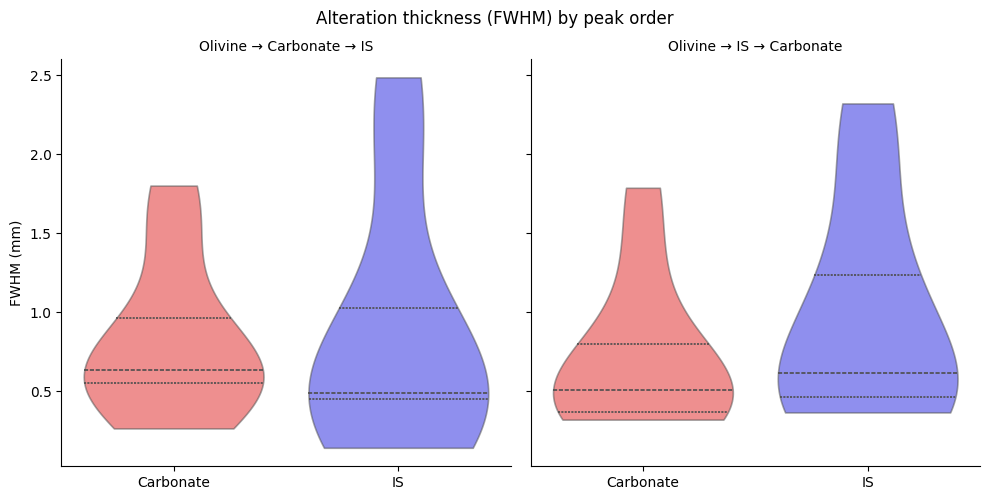

In [27]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --- config (plot-only mappings; does not modify metrics_df) ---
fwhm_cols = {'fwhm_Carb': 'Carb', 'fwhm_IS': 'IS'}

display_names = {
    'Carb': 'Carbonate',
    'IS': 'IS',
}

orders = ['Olivine->Carb->IS', 'Olivine->IS->Carb']


def pretty_peak_order(order: str) -> str:
    """Convert 'Olivine->Carb->IS' -> 'Olivine → Carbonate → IS'."""
    parts = order.split('->')
    parts = [display_names.get(p, p) for p in parts]
    return ' \u2192 '.join(parts)  # arrow: →


# --- tidy data for plotting ---
subset = metrics_df.loc[metrics_df['peak_order'].isin(orders), ['peak_order', *fwhm_cols.keys()]].copy()

long_plot = (
    subset.melt(
        id_vars='peak_order',
        value_vars=list(fwhm_cols.keys()),
        var_name='MineralKey',
        value_name='FWHM',
    )
    .replace({'MineralKey': fwhm_cols})
    .assign(
        FWHM_mm=lambda d: d['FWHM'] * 1000.0,
        MineralLabel=lambda d: d['MineralKey'].replace(display_names),
        peak_order_label=lambda d: d['peak_order'].map(pretty_peak_order),
    )
)

# keep consistent ordering on the x-axis
x_order = ['Carbonate', 'IS']

# color mapping (must match x labels if x is MineralLabel)
palette = {'Carbonate': 'red', 'IS': 'blue'}

# --- plot ---
g = sns.catplot(
    kind='violin',
    data=long_plot,
    x='MineralLabel',
    y='FWHM_mm',
    order=x_order,
    col='peak_order_label',
    sharey=True,
    inner='quartile',
    cut=0,
    palette=palette,
    linewidth=1.2,
)

g.set_axis_labels('', 'FWHM (mm)')
g.set_titles('{col_name}')
plt.suptitle('Alteration thickness (FWHM) by peak order', y=1.03)

# Optional: make the filled violins semi-transparent (helps compare overlaps/edges)
for ax in g.axes.flat:
    for coll in ax.collections:
        try:
            coll.set_alpha(0.5)
        except Exception:
            pass

plt.savefig(os.path.join(outdir_root, "Violin.png"), dpi=300, bbox_inches='tight')
plt.show()


## 15) Hydrated Carbonate Plots

In [29]:
# --- Drop-in: carbonate opacity + TOTAL (wt%) color overlay (Plotly, uses I_COL/J_COL) ---

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64

def plot_carbonate_total_overlay_plotly(
    df: pd.DataFrame,
    image_path: str,
    carbonate_col: str = None,          # defaults to your mapping for carbonate
    totals_col: str = "TOTAL (wt%)",    # exact column name in your df
    xcol: str = None,                   # defaults to I_COL
    ycol: str = None,                   # defaults to J_COL
    point_size: int = 7
):
    # Defaults from your earlier config/mapping
    if carbonate_col is None:
        carbonate_col = MINERAL_COLS.get("Carb", "Carbonate_wt")
    if xcol is None: xcol = I_COL
    if ycol is None: ycol = J_COL

    needed = [carbonate_col, totals_col, xcol, ycol]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print(f"Missing columns in df: {missing}")
        return

    # Load background image
    img = Image.open(image_path).convert("RGBA")
    w, h = img.size
    buf = BytesIO(); img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    # Data
    x = pd.to_numeric(df[xcol], errors="coerce").to_numpy(float)
    y = pd.to_numeric(df[ycol], errors="coerce").to_numpy(float)
    carb = pd.to_numeric(df[carbonate_col], errors="coerce").to_numpy(float)
    tot  = pd.to_numeric(df[totals_col], errors="coerce").to_numpy(float)

    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(carb) & np.isfinite(tot)
    if not np.any(m):
        print("No valid points to plot.")
        return
    x, y, carb, tot = x[m], y[m], carb[m], tot[m]

    # -------- BALANCED OPACITY BANDS (carbonate drives opacity) --------
    # Lowest carbonate band invisible; generous mid-range visibility; top fully opaque.
    if np.any(np.isfinite(carb)):
        qs = [0, 20, 40, 60, 80, 95, 100]  # 7 edges → 6 bands
        edges = np.percentile(carb, qs).tolist()
        # ensure strict monotonicity even with ties
        for i in range(1, len(edges)):
            if edges[i] <= edges[i-1]:
                edges[i] = edges[i-1] + 1e-12
    else:
        edges = [0, 1, 2, 3, 4, 5, 6]

    band_opacities = [0.00, 0.18, 0.35, 0.55, 0.78, 1.00]

    # Color from TOTAL (wt%): blue (low) → red (high)
    cmin = float(np.nanmin(tot))
    cmax = float(np.nanmax(tot)) if np.nanmax(tot) > cmin else (cmin + 1e-9)
    colorscale = [(0.0, "#0000ff"), (1.0, "#ff0000")]  # blue → red

    # Build figure
    fig = go.Figure()
    fig.add_layout_image(dict(
        source='data:image/png;base64,' + b64,
        xref='x', yref='y', x=0, y=0, sizex=w, sizey=h,
        sizing='stretch', layer='below'
    ))

    # Add 6 opacity-banded traces; only the first shows the colorbar
    for i in range(len(band_opacities)):
        lo, hi = edges[i], edges[i+1]
        mk = (carb >= lo) & (carb <= hi)
        if not np.any(mk):
            continue
        fig.add_trace(go.Scattergl(
            x=x[mk], y=y[mk], mode="markers",
            marker=dict(
                size=point_size,
                symbol="square",              # squares instead of circles
                color=tot[mk],                # TOTAL drives color
                colorscale=colorscale,
                cmin=cmin, cmax=cmax,
                showscale=(i == 0),           # single shared colorbar
                colorbar=dict(title="TOTAL (wt%)", thickness=18),
                opacity=band_opacities[i],
                line=dict(width=0)
            ),
            name="", showlegend=False
        ))

    # Axes & layout
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor='x')
    fig.update_layout(
        title="Carbonate (opacity) + TOTAL (wt%) (color) Overlay",
        width=800, height=int(800 * h / w),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    return fig

# Example call
plot_carbonate_total_overlay_plotly(df, image_path)